# cis-isoQTL analysis
- 1. expression processing

After nominal pass:
- 2. determine optimal #HCP from nominal associations
- 3. visualize expression regressed by covariates, check batch effect
- maybe: Relative log-expression RLE plots

After permutation pass:
- 4. check beta approximated permutation pval
- 5. grouped permutation
- 6. QTL TSS distance density plot
- 7. Compare sig feature across ancestries, upsetR
- 8. (ABANDONED) correlation of QTL effect size
- 9. (TODO) compare with adult
- 10. isoGene type
- 11. conditional pass
- 12. Susie

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(data.table))
suppressMessages(library(VennDiagram))
suppressMessages(library(UpSetR))
# suppressMessages(library(patchwork))
# suppressMessages(library(ggridges))
suppressMessages(library(DESeq2))
suppressMessages(library(WGCNA))
suppressMessages(library(sva))
suppressMessages(library(edgeR))
library(ggsignif)
library(ggsci)

In [2]:
setwd("~/project-gandalm/isoform_twas/isoqtl_new/")

### 1: Expression processing

In [3]:
datExpr <- fread("../salmon/expression.final/tx.counts.scaled.tsv", data.table = F)
gtf <- fread("../salmon/gencode.tx.tsv", data.table = F)

# remove chrM, chrX, chrY
# walker and hdbr duplicate 1707
# make hdbr 1707.1
names(datExpr)[647] <- "1707.1"
gtf <- gtf %>% filter(!(V1 %in% c("chrX","chrY","chrM")))
datExpr <- datExpr %>% filter(V1 %in% gtf$V5)
gtf <- gtf %>% filter(V5 %in% datExpr$V1)

rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]
datExpr <- round(datExpr)

dim(gtf)
dim(datExpr)

Warning message in fread("../salmon/expression.final/tx.counts.scaled.tsv", data.table = F):
“Detected 654 column names but the data has 655 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 220872      5

[1] 220872    654

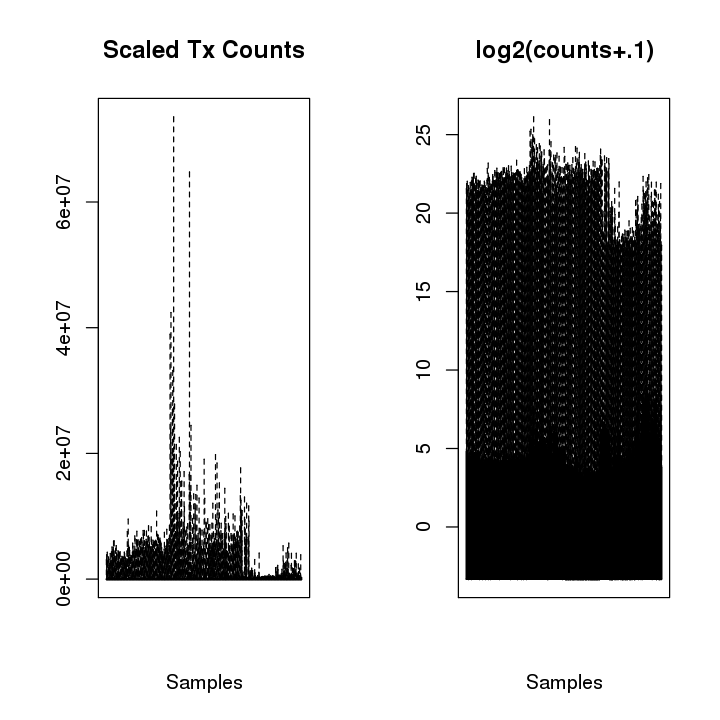

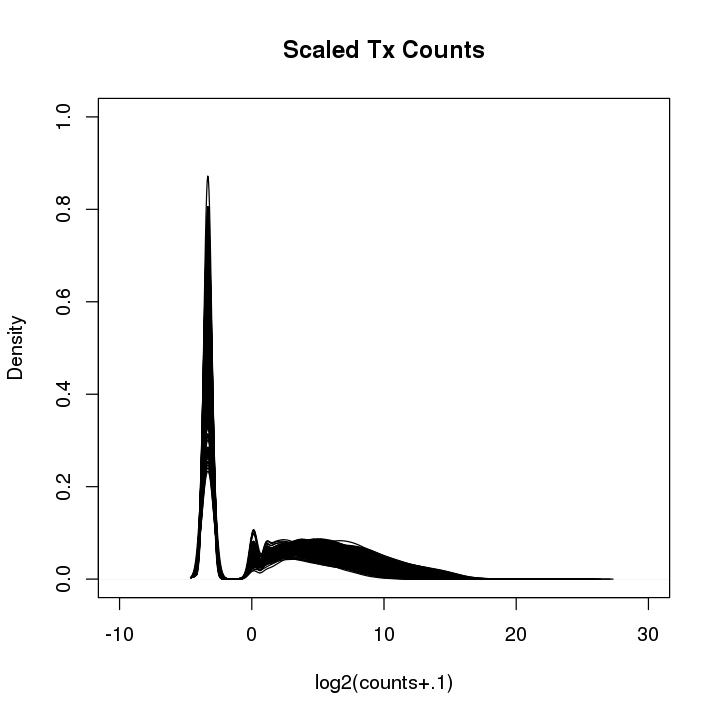

In [21]:
options(repr.plot.height = 6, repr.plot.width = 6)
# View the distribution of expression for each sample.
# box plot, looking for big differences in read depth (raw counts), symmetry in distribution across samples
par(mfrow=c(1,2))
boxplot(datExpr, range = 0, main = 'Scaled Tx Counts', xlab = 'Samples', xaxt = "n")
boxplot(log2(.1+datExpr), range = 0, main = 'log2(counts+.1)', xlab = 'Samples', xaxt = "n")

# Histogram/density plot
# Look for: how well do the distributions line up, outlier samples, zero counts
par(mfrow=c(1,1))
i <- 1
plot(density(log2(.1+datExpr[,i])), main = 'Scaled Tx Counts', xlab = 'log2(counts+.1)', 
     xlim = c(-10,30), ylim = c(0,1))
for(i in 2:ncol(datExpr)){
  lines(density(log2(.1+datExpr[,i])))
}

In [4]:
# Remove lowly expressed
datExpr.tpm <- fread("../salmon/expression.final/tx.TPM.tsv", data.table = F)
names(datExpr.tpm)[647] <- "1707.1"
datExpr.tpm <- datExpr.tpm %>% filter(V1 %in% gtf$V5)
rownames(datExpr.tpm) <- datExpr.tpm$V1
datExpr.tpm <- datExpr.tpm[,-1]

Warning message in fread("../salmon/expression.final/tx.TPM.tsv", data.table = F):
“Detected 654 column names but the data has 655 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [5]:
# Select cutoff
# cutoff = 0
cut0_df <- data.frame("subjProportion" = seq(0.1, 1, 0.1),
                      "numFeature" = NA)
for(i in seq(0.1, 1, 0.1)) {
  keep <- (rowSums(datExpr.tpm > 0)) > i*dim(datExpr.tpm)[2]
  cut0_df[which(cut0_df$subjProportion==i),"numFeature"] <- sum(keep)
}
cut0_df$cutoff <- rep(0, 10)

# cutoff = 0.1
cut1_df <- data.frame("subjProportion" = seq(0.1, 1, 0.1),
                      "numFeature" = NA)
for(i in seq(0.1, 1, 0.1)) {
  keep <- (rowSums(datExpr.tpm > .1)) > i*dim(datExpr.tpm)[2]
  cut1_df[which(cut1_df$subjProportion==i),"numFeature"] <- sum(keep)
}
cut1_df$cutoff <- rep(.1, 10)

# cutoff = 0.5
cut5_df <- data.frame("subjProportion" = seq(0.1, 1, 0.1),
                      "numFeature" = NA)
for(i in seq(0.1, 1, 0.1)) {
  keep <- (rowSums(datExpr.tpm > .5)) > i*dim(datExpr.tpm)[2]
  cut5_df[which(cut5_df$subjProportion==i),"numFeature"] <- sum(keep)
}
cut5_df$cutoff <- rep(.5, 10)

# cutoff = 1
cut10_df <- data.frame("subjProportion" = seq(0.1, 1, 0.1),
                      "numFeature" = NA)
for(i in seq(0.1, 1, 0.1)) {
  keep <- (rowSums(datExpr.tpm > 1)) > i*dim(datExpr.tpm)[2]
  cut10_df[which(cut10_df$subjProportion==i),"numFeature"] <- sum(keep)
}
cut10_df$cutoff <- rep(1, 10)


cut_df <- rbind(cut0_df, cut1_df, cut5_df, cut10_df)
cut_df$cutoff <- as.factor(cut_df$cutoff)

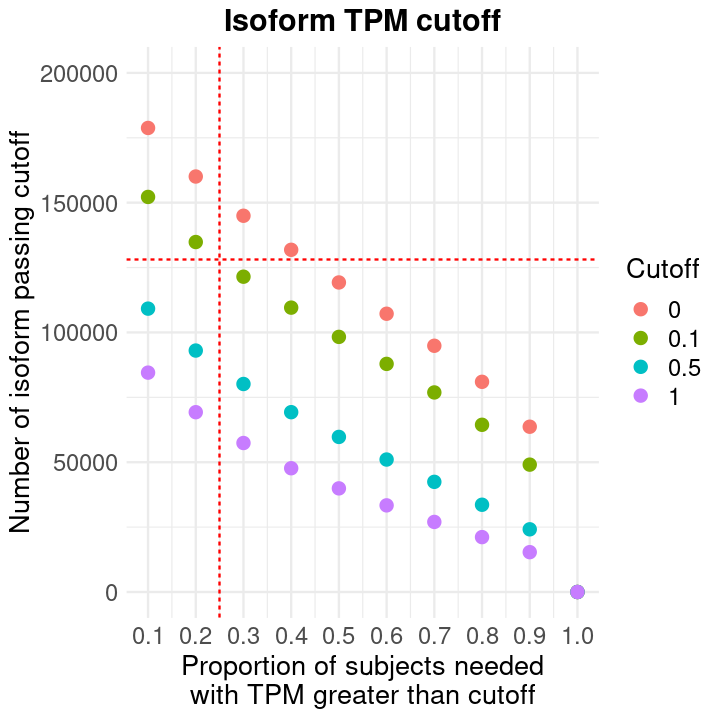

In [12]:
options(repr.plot.height = 6, repr.plot.width = 6)

ggplot(cut_df, aes(x = subjProportion, y = numFeature, color = cutoff)) +
  geom_point(size = 3) +
  labs(x = "Proportion of subjects needed\nwith TPM greater than cutoff",
       y = "Number of isoform passing cutoff",
       title = "Isoform TPM cutoff",
       color = "Cutoff") +
  theme_minimal() +
  theme(axis.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14)) +
  scale_x_continuous(breaks = seq(0,1,0.1)) +
  ylim(0,200000) +
  geom_vline(xintercept = 0.25, linetype = "dashed", color = "red") +
  geom_hline(yintercept = 127986, linetype = "dashed", color = "red")

In [13]:
ggsave("figures/cutoff.pdf", width = 6, height = 6)

In [8]:
# cutoff=0.1, 25% subjects
keep <- (rowSums(datExpr.tpm > .1)) > 0.25*ncol(datExpr.tpm)
table(keep)

keep
 FALSE   TRUE 
 92886 127986 

In [9]:
datExpr <- datExpr[keep,]
datExpr.tpm <- datExpr.tpm[keep,]

In [10]:
# use varianceStabilizingTransformation in actual script
datExpr.vst <- vst(as.matrix(datExpr), blind = TRUE)
# datExpr.vst <- varianceStabilizingTransformation(as.matrix(datExpr), blind = TRUE)
# meanSdPlot(as.matrix(datExpr.vst))
datExpr.vst <- as.data.frame(datExpr.vst)

converting counts to integer mode



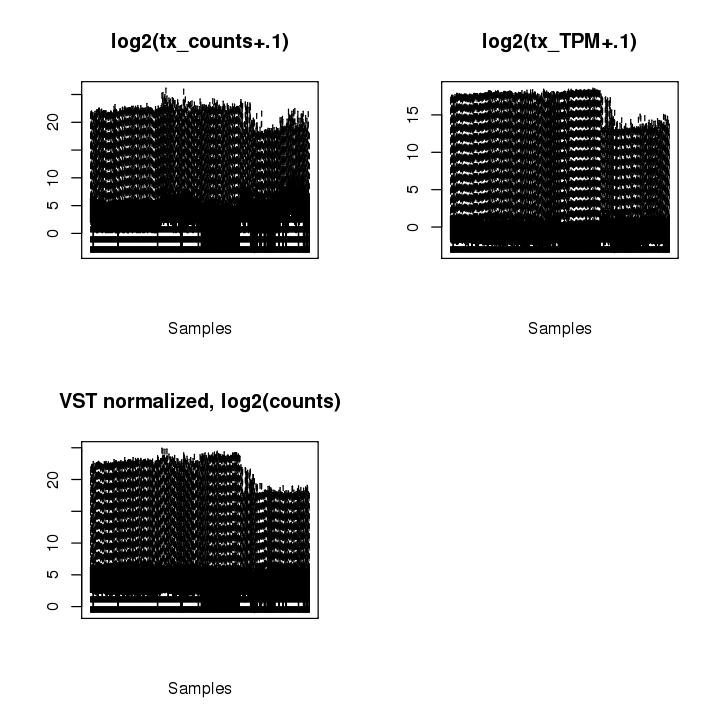

In [97]:
# check depth normalization, in log2 scale
par(mfrow=c(2, 2))
boxplot(log2(.1+datExpr), range=0, main = "log2(tx_counts+.1)", xlab="Samples",xaxt="n")
boxplot(log2(.1+datExpr.tpm), range=0, main = "log2(tx_TPM+.1)", xlab="Samples",xaxt="n")
# boxplot(datExpr.cpm, range=0, main = "TMM normalized, logCPM", xlab="Samples",xaxt="n")
boxplot(datExpr.vst, range=0, main = "VST normalized, log2(counts)", xlab="Samples",xaxt="n")

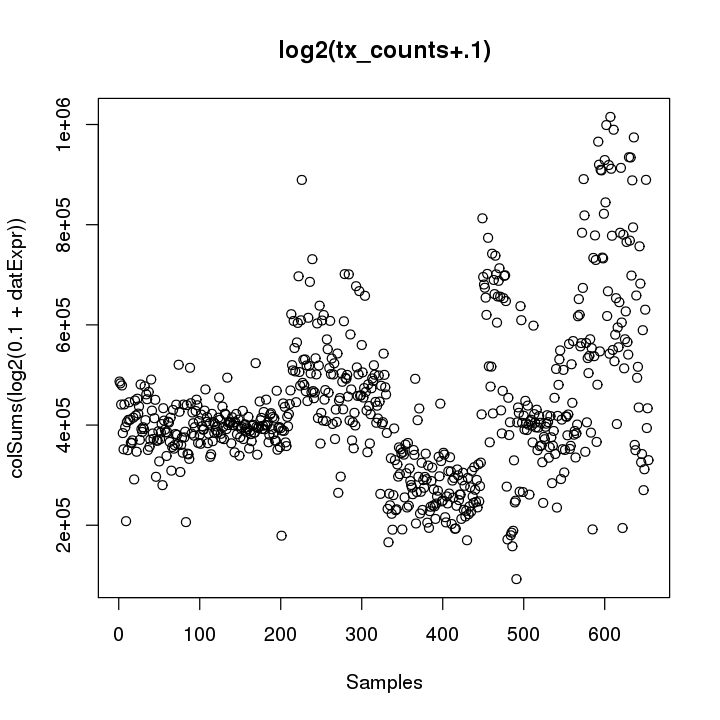

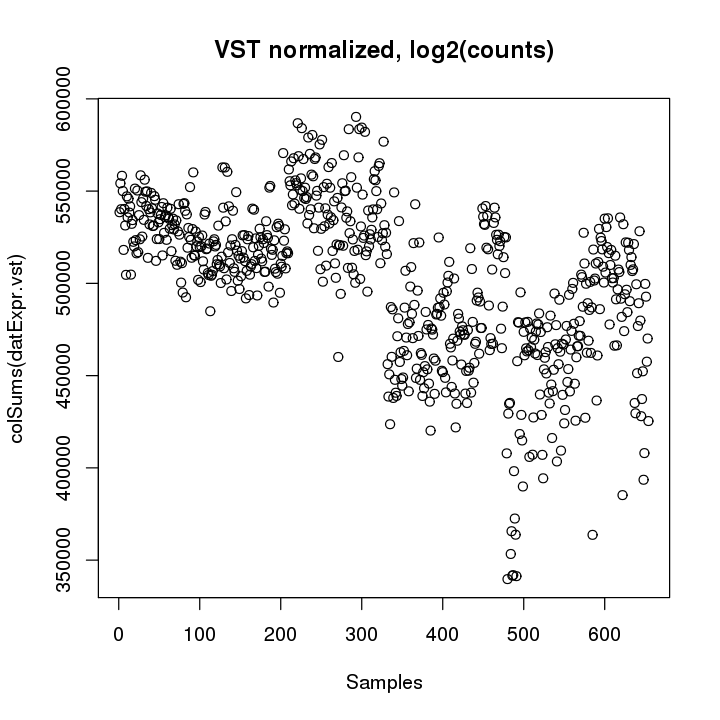

In [98]:
plot(colSums(log2(.1+datExpr)), main = "log2(tx_counts+.1)", xlab="Samples")
# plot(colSums(log2(.1+datExpr.tpm)), main = "log2(gene_TPM+.1)", xlab="Samples")
# plot(colSums(datExpr.tpm), main = "gene_TPM", xlab="Samples")
# plot(colSums(datExpr.cpm), main = "TMM normalized, logCPM", xlab = "Samples")
plot(colSums(datExpr.vst), main = "VST normalized, log2(counts)", xlab = "Samples")

In [11]:
# Outlier detection
normadj <- adjacency(datExpr.vst,type = 'signed',corFnc = 'bicor')   #Calculate network adjacency
netsummary <- fundamentalNetworkConcepts(normadj)
C <- netsummary$Connectivity   #Extract connectivity of each sample
Z.C <- (C-mean(C))/sqrt(var(C))   #Covert to Z-score

Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


ERROR: Error in plot.new(): figure margins too large


In [23]:
par(mfrow=c(1,1))
pdf("figures/outlier.pdf", width = 6, height = 6)
plot(1:length(Z.C), Z.C, main = "Outlier Plot", xlab = "Samples",ylab = "Connectivity Z Score", cex.main = 1.2)
abline(h=-3, col="red")
dev.off()

png 
  2

In [14]:
outliers <- (Z.C < -3)
outlier.df <- data.frame(c(which(outliers)))
outlier.df$c.which.outliers.. <- rownames(outlier.df)
outlier.df

,c.which.outliers..
,<chr>
17111,17111
17486,17486
19031,19031
HSB194,HSB194
Br2396,Br2396
Br2403,Br2403
Br2410,Br2410
Br2411,Br2411
Br2413,Br2413


**See `eqtl_analysis.ipynb` for additional sanity check plots**

### 2: Optimal number of HCP

In [3]:
# options(repr.plot.width = 6, repr.plot.height = 6)
df_all <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df_all[i/10, "Count"] <- read.table(paste0("results/mixed_nominal_", i, 
                                           "hcp/significant_feature_count.txt"))[,1]
}

# p1 <- ggplot(df) + 
#     geom_point(aes(x=HCP, y=Count), color = "purple") +
#     geom_line(aes(x=HCP, y=Count), color = "purple") +
#     scale_x_continuous(breaks = seq(0,110,by = 10)) +
#     geom_vline(xintercept = 70, color = "red") +
#     labs(title = "ALL, n=626",
#          x = "",
#          y = "") +
#     theme_classic() +
#     theme(axis.text = element_text(size=16),
#           axis.title = element_text(size=18),
#           plot.title = element_text(size=18, face="bold", hjust = 0.5))
# p1

In [4]:
df_eur <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df_eur[i/10, "Count"] <- read.table(paste0("results/eur_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

# p2 <- ggplot(df) + 
#     geom_point(aes(x=HCP, y=Count), color = "purple") +
#     geom_line(aes(x=HCP, y=Count), color = "purple") +
#     scale_x_continuous(breaks = seq(0,110,by = 10)) +
#     geom_vline(xintercept = 60, color = "red") +
#     labs(title = "EUR, n=277",
#          x = "",
#          y = "") +
#     theme_classic() +
#     theme(axis.text = element_text(size=16),
#           axis.title = element_text(size=18),
#           plot.title = element_text(size=18, face="bold", hjust = 0.5))
# p2

In [5]:
df_amr <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df_amr[i/5, "Count"] <- read.table(paste0("results/amr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

# p3 <- ggplot(df) + 
#     geom_point(aes(x=HCP, y=Count), color = "purple") +
#     geom_line(aes(x=HCP, y=Count), color = "purple") +
#     scale_x_continuous(breaks = seq(0,55,by = 5)) +
#     geom_vline(xintercept = 15, color = "red") +
#     labs(title = "AMR, n=162",
#          x = "",
#          y = "") +
#     theme_classic() +
#     theme(axis.text = element_text(size=16),
#           axis.title = element_text(size=18),
#           plot.title = element_text(size=18, face="bold", hjust = 0.5))
# p3

In [6]:
df_afr <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df_afr[i/5, "Count"] <- read.table(paste0("results/afr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

# p4 <- ggplot(df) + 
#     geom_point(aes(x=HCP, y=Count), color = "purple") +
#     geom_line(aes(x=HCP, y=Count), color = "purple") +
#     scale_x_continuous(breaks = seq(0,55,by = 5)) +
#     geom_vline(xintercept = 20, color = "red") +
#     labs(title = "AFR, n=135",
#          x = "",
#          y = "") +
#     theme_classic() +
#     theme(axis.text = element_text(size=16),
#           axis.title = element_text(size=18),
#           plot.title = element_text(size=18, face="bold", hjust = 0.5))
# p4

In [7]:
df <- rbind(df_all, df_eur, df_amr, df_afr)
df$Population <- c(rep("ALL (n=626)", 10), rep("EUR (n=277)", 10), rep("AMR (n=162)", 10), rep("AFR (n=135)", 10))
df$Population <- factor(df$Population, levels = c("ALL (n=626)", "EUR (n=277)", "AMR (n=162)", "AFR (n=135)"))

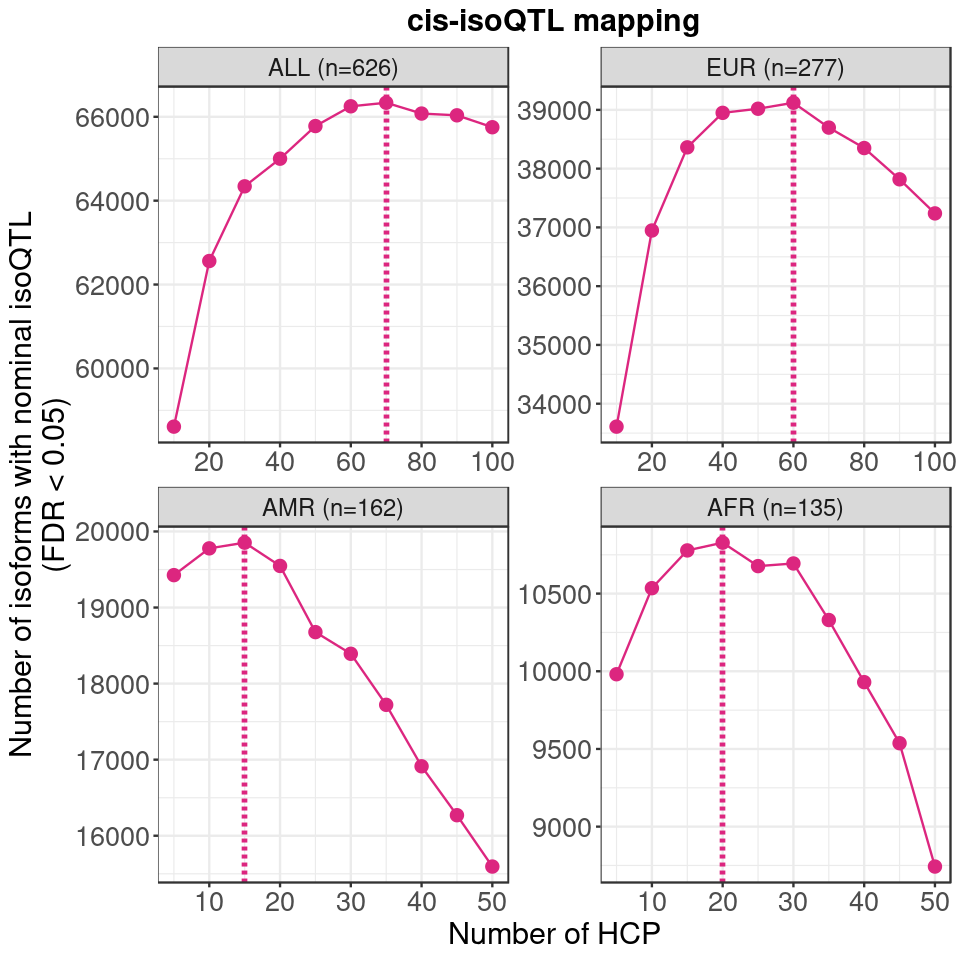

In [10]:
options(repr.plot.width = 8, repr.plot.height = 8)

all_seg <- data.frame(x = 70, y = 58612, xend = 70, yend = 66335, Population = "ALL (n=626)")
eur_seg <- data.frame(x = 60, y = 33610, xend = 60, yend = 39121, Population = "EUR (n=277)")
amr_seg <- data.frame(x = 15, y = 15595, xend = 15, yend = 19853, Population = "AMR (n=162)")
afr_seg <- data.frame(x = 20, y = 8743, xend = 20, yend = 10828, Population = "AFR (n=135)")

seg <- rbind(all_seg, eur_seg, amr_seg, afr_seg)
seg$Population <- factor(seg$Population, levels = c("ALL (n=626)", 
                                                    "EUR (n=277)", 
                                                    "AMR (n=162)", 
                                                    "AFR (n=135)"))

# can modify x ticks
breaks_fun <- function(x) {
  if (max(x) > 55) {
    seq(0, 110, 20)
  } else {
    seq(0, 55, 10)
  }
}

ggplot(df, aes(x = HCP, y = Count)) +
  geom_point(size = 3, color = "#DC267F") +
  geom_line(color = "#DC267F") +
  facet_wrap(~Population, scales = "free") +
#   geom_segment(data = seg, aes(x=x, y=y, xend=xend, yend=yend), 
#                linetype = "dashed", color = "#DC267F", size = 1.2) +
  labs(x = "Number of HCP", 
       y = "Number of isoforms with nominal isoQTL\n(FDR < 0.05)", 
       title = "cis-isoQTL mapping") +
  scale_x_continuous(breaks = breaks_fun) + 
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        strip.text.x = element_text(size = 14)) +
    geom_vline(data = seg, aes(xintercept = x), linetype = "dashed", size = 1.2, color = "#DC267F")

In [11]:
ggsave("figures/nominal.pdf", height = 8, width = 8)

### 3: Isoform expression regression, check batch effects

In [44]:
rel <- read.table("../genotype/all_data/isec_R2_greater_than_3/ancestry/related.txt")[,1]

In [45]:
datExpr <- fread("data/tx.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/tx.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/70hcp_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3_all <- rbind(data, data1, data2)

data3_all$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized isoform counts", dim(data2)[1]))

Warning message in fread("data/tx.counts.processed.tsv", data.table = F):
“Detected 639 column names but the data has 640 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("data/tx.counts.processed.noComBat.tsv", data.table = F):
“Detected 639 column names but the data has 640 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  77 626

[1] 127986    626

[1] 127986    626

In [46]:
datExpr <- fread("data/eur/tx.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/eur/tx.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/eur/60HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3_eur <- rbind(data, data1, data2)

data3_eur$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized isoform counts", dim(data2)[1]))

Warning message in fread("data/eur/tx.counts.processed.tsv", data.table = F):
“Detected 281 column names but the data has 282 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("data/eur/tx.counts.processed.noComBat.tsv", data.table = F):
“Detected 281 column names but the data has 282 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  67 277

[1] 127986    277

[1] 127986    277

In [47]:
datExpr <- fread("data/amr/tx.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/amr/tx.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/amr/15HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3_amr <- rbind(data, data1, data2)

data3_amr$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized isoform counts", dim(data2)[1]))

Warning message in fread("data/amr/tx.counts.processed.tsv", data.table = F):
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("data/amr/tx.counts.processed.noComBat.tsv", data.table = F):
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  22 162

[1] 127986    162

[1] 127986    162

In [48]:
datExpr <- fread("data/afr/tx.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/afr/tx.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/afr/20HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3_afr <- rbind(data, data1, data2)

data3_afr$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized isoform counts", dim(data2)[1]))

Warning message in fread("data/afr/tx.counts.processed.tsv", data.table = F):
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("data/afr/tx.counts.processed.noComBat.tsv", data.table = F):
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  27 135

[1] 127986    135

[1] 127986    135

In [49]:
df <- rbind(data3_all, data3_eur, data3_amr, data3_afr)
df$Population <- c(rep("ALL", 626*3), 
                   rep("EUR", 277*3), 
                   rep("AMR", 162*3), 
                   rep("AFR", 135*3))
df$Population <- factor(df$Population, 
                        levels = c("ALL", "EUR", "AMR", "AFR"))

colnames(df)[3] <- "Dataset"

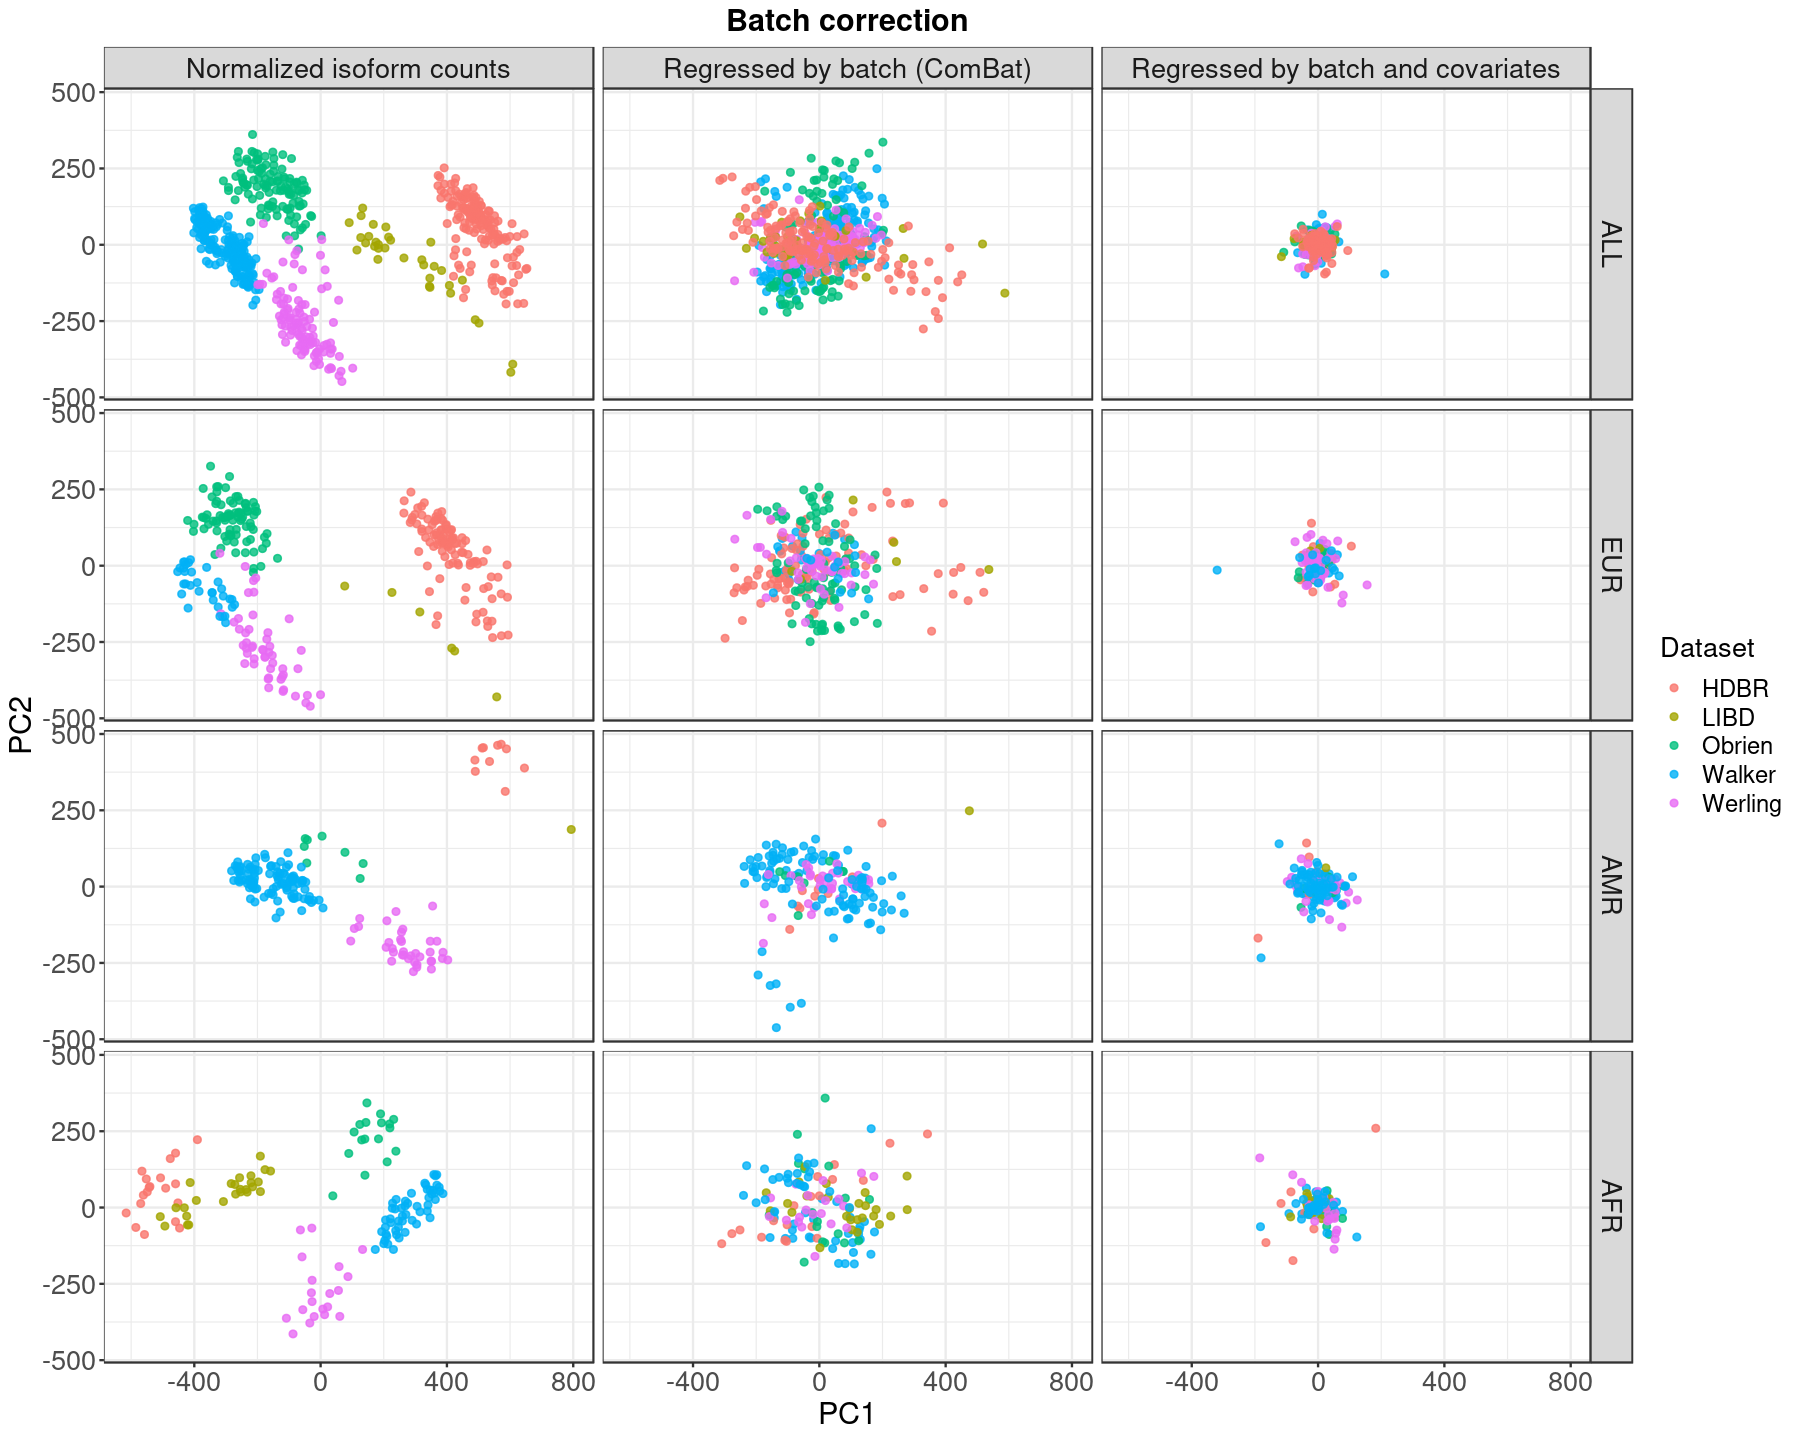

In [50]:
options(repr.plot.height = 12, repr.plot.width = 15)

ggplot(df, aes(x = PC1, y = PC2, color = Dataset)) +
  geom_point(alpha = 0.8) +
  facet_grid(Population ~ group, scales = "fixed") +
  labs(x = "PC1", y = "PC2", 
       title = "Batch correction") +
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        strip.text = element_text(size = 16),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14))

ggsave("figures/regress.pdf", width = 15, height = 12)

### 4: Check beta-approximated permutation pval

In [51]:
mixed <- fread("results/mixed_perm_70hcp/all.chunks.txt.gz", data.table=F)
colnames(mixed) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
mixed <- mixed[complete.cases(mixed),]
mixed <- arrange(mixed, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
# round(cor(mixed[, 'ppval'], mixed[, 'bpval']), 4)

In [52]:
eur <- fread("results/eur_perm_60HCP/all.chunks.txt.gz", data.table=F)
colnames(eur) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
eur <- eur[complete.cases(eur),]
eur <- arrange(eur, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
# round(cor(eur[, 'ppval'], eur[, 'bpval']), 4)

In [53]:
amr <- fread("results/amr_perm_15HCP/all.chunks.txt.gz", data.table=F)
colnames(amr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
amr <- amr[complete.cases(amr),]
amr <- arrange(amr, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
# round(cor(amr[, 'ppval'], amr[, 'bpval']), 4)

In [54]:
afr <- fread("results/afr_perm_20HCP/all.chunks.txt.gz", data.table=F)
colnames(afr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
afr <- afr[complete.cases(afr),]
afr <- arrange(afr, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
# round(cor(afr[, 'ppval'], afr[, 'bpval']), 4)

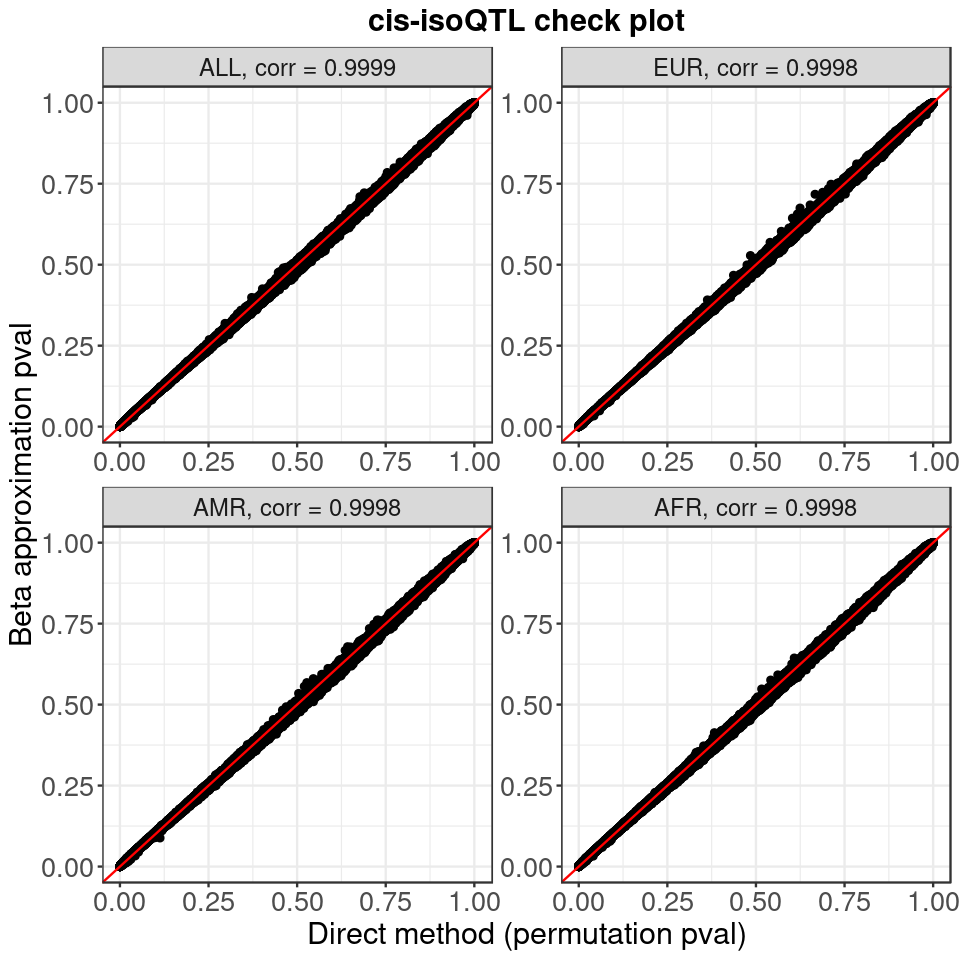

In [55]:
df <- rbind(mixed, eur, amr, afr)
df$Population <- c(rep("ALL, corr = 0.9999", nrow(mixed)), 
                   rep("EUR, corr = 0.9998", nrow(eur)), 
                   rep("AMR, corr = 0.9998", nrow(amr)),
                   rep("AFR, corr = 0.9998", nrow(afr)))
df$Population <- factor(df$Population, levels = c("ALL, corr = 0.9999", 
                                                  "EUR, corr = 0.9998", 
                                                  "AMR, corr = 0.9998", 
                                                  "AFR, corr = 0.9998"))

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(df, aes(x = ppval, y = bpval)) +
  geom_point() +
  geom_abline(intercept = 0, slope = 1, color = "red") +
  facet_wrap(~Population, scales = "free") +
  labs(x = "Direct method (permutation pval)", 
       y = "Beta approximation pval", 
       title = "cis-isoQTL check plot") +
#   scale_x_continuous(breaks = breaks_fun) + 
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        strip.text.x = element_text(size = 14))

ggsave("figures/check.pdf", height = 8, width = 8)

### 5: compare isoGene: with and without grouped permutation (ALL)

In [56]:
mixed_sig <- read.table("results/mixed_perm_70hcp/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc <- fread("results/mixed_perm_70hcp/all_assoc.txt.gz", data.table = F)

eur_sig <- read.table("results/eur_perm_60HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc_eur <- fread("results/eur_perm_60HCP/all_assoc.txt.gz", data.table = F)

amr_sig <- read.table("results/amr_perm_15HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc_amr <- fread("results/amr_perm_15HCP/all_assoc.txt.gz", data.table = F)

afr_sig <- read.table("results/afr_perm_20HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc_afr <- fread("results/afr_perm_20HCP/all_assoc.txt.gz", data.table = F)

In [57]:
tx2gene <- read.table("../salmon/tx2gene_gencode_v33_noGeneVersion.tsv", header=T, stringsAsFactors=F)

In [58]:
mixed_sig <- mixed_sig %>% left_join(tx2gene, by = c("pid" = "Tx"))
eur_sig <- eur_sig %>% left_join(tx2gene, by = c("pid" = "Tx"))
# write.table(eur_sig, "results/eur_perm_60HCP/sig_pheno_gene.txt", col.names=T, row.names=F, sep="\t", quote=F)
amr_sig <- amr_sig %>% left_join(tx2gene, by = c("pid" = "Tx"))
# write.table(amr_sig, "results/amr_perm_15HCP/sig_pheno_gene.txt", col.names=T, row.names=F, sep="\t", quote=F)
afr_sig <- afr_sig %>% left_join(tx2gene, by = c("pid" = "Tx"))
# write.table(afr_sig, "results/afr_perm_20HCP/sig_pheno_gene.txt", col.names=T, row.names=F, sep="\t", quote=F)

In [6]:
length(unique(mixed_sig$Gene))

[1] 11468

**Grouped permutation results**

In [59]:
mixed_group <- fread("results/mixed_grp_perm_70hcp/group.perm.genes.txt.gz", data.table = F)
head(mixed_group)

,gene_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,tss_distance,ma_samples,ma_count,...,ref_factor,pval_nominal,slope,slope_se,pval_perm,pval_beta,group_id,group_size,qval,pval_nominal_threshold
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,...,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
1,ENST00000456328.2_1:ENSG00000223972,846,1.03391,153.810,472.615,0.000277306,chr1:935662,859173,14,14,...,1,9.17017e-05,0.0480143,0.01218360,0.0332967,0.0369681,ENSG00000223972,1,0.0379578,0.000388848
2,ENST00000473358.1_1:ENSG00000243485,882,1.01921,160.210,472.148,0.002260950,rs58879223,862458,48,50,...,1,1.01256e-03,-0.0232775,0.00704346,0.2932900,0.2953390,ENSG00000243485,1,0.1766770,0.000355642
3,ENST00000488147.1_2:ENSG00000227232,882,1.03391,164.177,481.710,0.006480150,rs74047413,845095,22,23,...,1,3.71668e-03,0.0284500,0.00976390,0.6533940,0.6419820,ENSG00000227232,1,0.2838210,0.000364301
4,ENST00000461467.1_2:ENSG00000237613,900,1.08949,141.258,445.279,0.012502100,rs74048004,981625,18,19,...,1,5.63050e-03,-0.0281826,0.01013920,0.8131600,0.8070160,ENSG00000237613,1,0.3252290,0.000503392
5,ENST00000495576.1_2:ENSG00000239945,1125,1.06696,164.354,451.342,0.014158000,rs534809610,877903,14,14,...,1,6.91359e-03,0.0336841,0.01242380,0.8913620,0.8925120,ENSG00000239945,1,0.3455850,0.000404123
6,ENST00000442987.3_1:ENSG00000233750,1334,1.02439,206.710,464.549,0.002985880,rs140316058,971632,17,17,...,1,1.27217e-03,-0.0365124,0.01127260,0.4619290,0.4492090,ENSG00000233750,1,0.2291940,0.000280446


In [8]:
dim(mixed_group)

[1] 30752    21

In [9]:
sum(complete.cases(mixed_group))

[1] 30752

In [60]:
mixed_group <- mixed_group %>% separate(gene_id, c("Tx", "Gene"), sep = ":", remove = FALSE)

In [16]:
length(unique(mixed_group$Gene))
length(unique(mixed_group$Tx))

[1] 30708

[1] 30748

In [17]:
mixed_group[duplicated(mixed_group$Tx),]

,gene_id,Tx,Gene,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,tss_distance,⋯,ref_factor,pval_nominal,slope,slope_se,pval_perm,pval_beta,group_id,group_size,qval,pval_nominal_threshold
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
3844,ENST00000302513.7_3:ENSG00000273045,ENST00000302513.7_3,ENSG00000273045,4369,1.02835,426.588,477.623,6.86996e-04,rs113073870,134681,⋯,1,2.79983e-04,0.0310305,0.00848556,0.24462400,2.41929e-01,ENSG00000273045,1,1.55341e-01,1.37698e-04
3845,ENST00000424491.5_1:ENSG00000241962,ENST00000424491.5_1,ENSG00000241962,4369,1.05101,366.308,457.845,5.73288e-20,rs115906416,62427,⋯,1,1.50359e-23,-0.0481738,0.00459603,0.00009999,2.89600e-18,ENSG00000241962,1,1.40340e-17,1.72533e-04
3846,ENST00000650052.1_2:ENSG00000273045,ENST00000650052.1_2,ENSG00000273045,4369,1.02682,1493.640,492.874,1.47894e-06,chr2:99109112,-32373,⋯,1,3.94149e-07,0.0139609,0.00271911,0.00119988,1.85122e-03,ENSG00000273045,3,2.61714e-03,3.91319e-05
3847,ENST00000465095.1_1:ENSG00000241962,ENST00000465095.1_1,ENSG00000241962,4369,1.03741,386.019,465.725,8.11756e-04,chr2:99449678,308192,⋯,1,2.83969e-04,-0.0100505,0.00275119,0.25431900,2.52786e-01,ENSG00000241962,1,1.59891e-01,1.56739e-04


In [14]:
mixed_group %>% filter(Tx == "ENST00000302513.7_3")

gene_id,Tx,Gene,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,tss_distance,...,ref_factor,pval_nominal,slope,slope_se,pval_perm,pval_beta,group_id,group_size,qval,pval_nominal_threshold
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,...,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
ENST00000302513.7_3:ENSG00000273045,ENST00000302513.7_3,ENSG00000273045,4369,1.05265,408.749,470.185,0.000756741,rs113073870,134681,...,1,0.000279983,0.0310305,0.00848556,0.244325,0.243506,ENSG00000273045,1,0.155936,0.000155426
ENST00000302513.7_3:ENSG00000273045,ENST00000302513.7_3,ENSG00000273045,4369,1.02835,426.588,477.623,0.000686996,rs113073870,134681,...,1,0.000279983,0.0310305,0.00848556,0.244624,0.241929,ENSG00000273045,1,0.155341,0.000137698


In [61]:
mixed_group_sig <- mixed_group %>% filter(qval < 0.05)
dim(mixed_group_sig)
length(unique(mixed_group_sig$Gene))

[1] 11861    23

[1] 11845

In [62]:
sum(unique(mixed_sig$Gene) %in% unique(mixed_group_sig$Gene))

[1] 10799

png 
  2

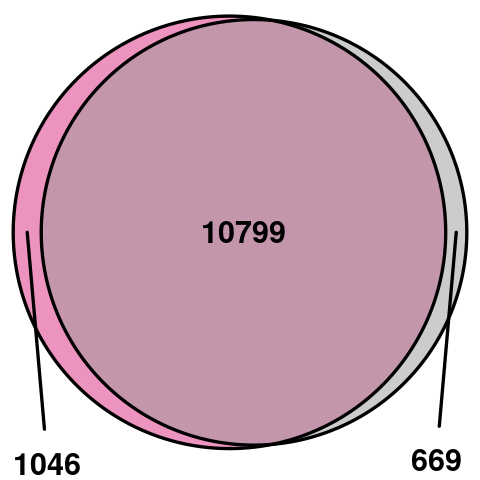

In [63]:
options(repr.plot.width = 4, repr.plot.height = 4)
venn.plot <- draw.pairwise.venn(11468, 11845, 10799, 
                                fill=c("#999999", "#DC267F"),
                                alpha=c(0.5,0.5), 
                                cex=1.5, 
                                fontface=2, 
                                fontfamily=rep("sans",3), 
                                category=c("", ""),
                                ext.text = TRUE,
                                ext.percent = c(0.1, 0.1, 0), # area 1, area2, overlapping
                                ext.pos = c(185, -185),
                                ext.dist = c(0.015, 0.015),
                                ext.line.lwd = 2,
                                ext.length = 0.85) # ext.line.lty available
pdf("figures/perm_group.pdf", width = 4, height = 4)
grid.draw(venn.plot)
dev.off()

**Compare isoform structure of isoGenes only identified in either group**

In [64]:
only_iso <- data.frame("Gene" = setdiff(unique(mixed_sig$Gene),unique(mixed_group_sig$Gene)),
                       "numIso" = NA)
dim(only_iso)

[1] 669   2

In [65]:
only_group <- data.frame("Gene" = setdiff(unique(mixed_group_sig$Gene),unique(mixed_sig$Gene)),
                       "numIso" = NA)
dim(only_group)

[1] 1046    2

In [66]:
grp.bed <- fread("data/tx_grp.bed.gz", data.table = F)

In [20]:
head(grp.bed)

,#Chr,start,end,ID,1474,1496,1500,1502,1507,1511,...,1558,1607,1707.1,1835,1851,1890,1923,2193,849,898
,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,11868,11869,ENST00000456328.2_1:ENSG00000223972,1.9628166,2.9903654,1.498273,2.388108,-1.4819497,1.502586,...,2.5415431,1.3311054,2.0884639,2.152905,1.825855,2.868941,2.5632874,-1.1385175,-1.1385175,-1.138518
2,1,29553,29554,ENST00000473358.1_1:ENSG00000243485,-0.7168836,-0.7168836,2.188171,2.328254,-0.7168836,3.386555,...,-1.3299522,-1.3299522,2.2633183,0.701678,2.344322,1.141864,1.2308510,1.7277431,2.4219361,1.344441
3,1,29569,29570,ENST00000488147.1_2:ENSG00000227232,7.9344376,7.9805499,8.420839,8.338557,7.9076500,8.715086,...,6.7357506,8.4469689,9.1996684,7.486056,8.671664,8.838924,7.6417155,8.5812056,7.1426363,8.179790
4,1,36080,36081,ENST00000461467.1_2:ENSG00000237613,2.7097751,3.1617278,3.673367,3.867543,3.8380508,2.079620,...,1.0463156,5.1999208,1.0463156,1.046316,1.046316,1.046316,1.0463156,5.4369537,1.0463156,1.046316
5,1,91104,91105,ENST00000495576.1_2:ENSG00000239945,-1.0440001,2.0627306,1.484179,3.232294,-1.0440001,-1.044000,...,-0.4367856,-0.4367856,-0.4367856,3.035855,5.240228,3.096245,-0.4367856,-0.4367856,-0.4367856,4.389807
6,1,131024,131025,ENST00000442987.3_1:ENSG00000233750,3.2910749,4.5993243,3.553063,4.362556,4.7390253,2.227817,...,3.8074711,3.4893689,3.8848810,2.500735,2.422406,3.635362,3.0320463,3.2391377,4.4564272,5.108879


In [67]:
grp.bed <- grp.bed %>% separate(ID, c("Tx", "Gene"), sep = ":", remove = FALSE)

In [24]:
length(unique(grp.bed$Tx))
length(unique(grp.bed$Gene))
dim(grp.bed)

[1] 127983

[1] 31121

[1] 127983    645

In [68]:
for(i in 1:nrow(only_iso)) {
    only_iso[i,'numIso'] <- nrow(grp.bed %>% filter(Gene == only_iso[i,'Gene']))
}
for(i in 1:nrow(only_group)) {
    only_group[i,'numIso'] <- nrow(grp.bed %>% filter(Gene == only_group[i,'Gene']))
}

In [28]:
mean(only_iso$numIso)
median(only_iso$numIso)
mean(only_group$numIso)
median(only_group$numIso)

[1] 12.26158

[1] 11

[1] 1.228489

[1] 1

In [79]:
compare <- rbind(only_iso, only_group)
compare$group <- c(rep("Isoform-level", nrow(only_iso)),
                   rep("Grouped", nrow(only_group)))

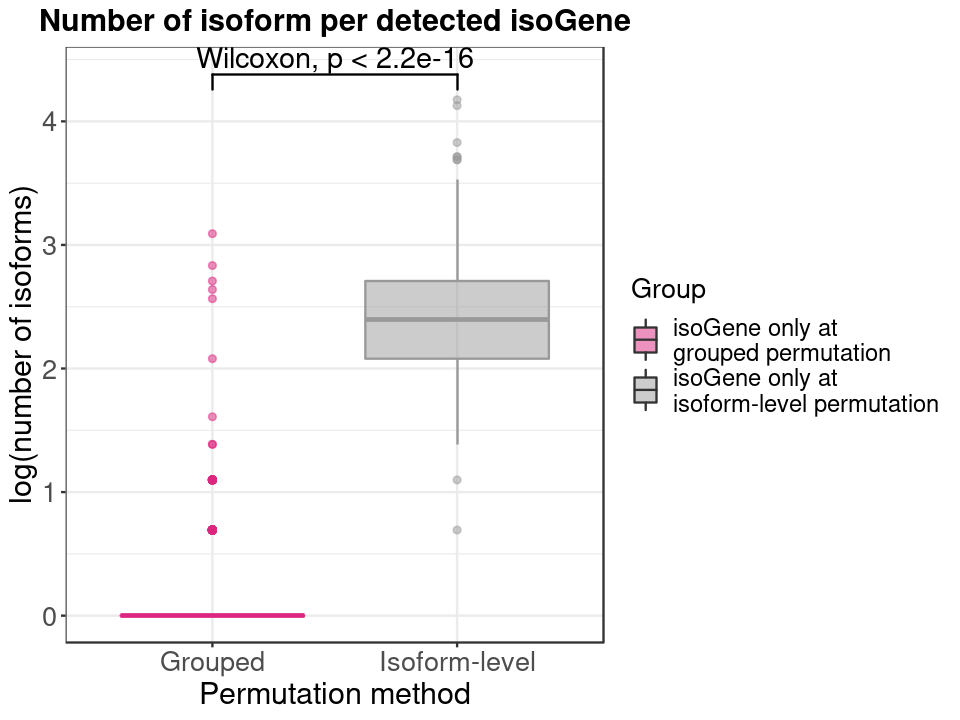

In [89]:
colors <- c("Isoform-level" = "#999999", 
            "Grouped" = "#DC267F")

options(repr.plot.height = 6, repr.plot.width = 8)

ggplot(compare, aes(x = group, y = log(numIso), 
                    fill = group, color = group)) +
    geom_boxplot(alpha = .5) +
    theme_bw() +
    labs(x = "Permutation method", 
         y = "log(number of isoforms)",
         title = "Number of isoform per detected isoGene") +
    scale_color_manual(values = colors, name = "", labels = "") +
    scale_fill_manual(values = colors,
                      name = "Group", 
                      labels = c("isoGene only at\ngrouped permutation",
                                 "isoGene only at\nisoform-level permutation")) +
    guides(color = "none") +
    theme(axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = "right",
          plot.title = element_text(size = 18, hjust = 0.5, face = "bold")) +
    geom_signif(
        comparisons = list(c("Grouped", "Isoform-level")),
        annotation = "Wilcoxon, p < 2.2e-16",
        textsize = 6,
        color = "black"
  )

In [86]:
ggsave("figures/isogene_compare.pdf", width = 8, height = 6)

In [87]:
wilcox.test(only_iso$numIso, only_group$numIso, alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  only_iso$numIso and only_group$numIso
W = 696870, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


### 6: dTSS

In [90]:
all_assoc <- all_assoc %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
all_assoc$sig <- as.factor(all_assoc$sig)

table(all_assoc$sig)
length(unique(all_assoc$pid))

all_assoc <- all_assoc %>% mutate(dist_kb = dist/1000)


non-significant     significant 
         103975           22891 

[1] 126866

In [91]:
all_assoc_eur <- all_assoc_eur %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
table(all_assoc_eur$sig)
length(unique(all_assoc_eur$pid))
all_assoc_eur <- all_assoc_eur %>% mutate(dist_kb = dist/1000)
all_assoc_eur$sig <- as.factor(all_assoc_eur$sig)

all_assoc_amr <- all_assoc_amr %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
table(all_assoc_amr$sig)
length(unique(all_assoc_amr$pid))
all_assoc_amr <- all_assoc_amr %>% mutate(dist_kb = dist/1000)
all_assoc_amr$sig <- as.factor(all_assoc_amr$sig)

all_assoc_afr <- all_assoc_afr %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
table(all_assoc_afr$sig)
length(unique(all_assoc_afr$pid))
all_assoc_afr <- all_assoc_afr %>% mutate(dist_kb = dist/1000)
all_assoc_afr$sig <- as.factor(all_assoc_afr$sig)


non-significant     significant 
         115194           11672 

[1] 126866


non-significant     significant 
         121118            5747 

[1] 126865


non-significant     significant 
         123146            3719 

[1] 126865

In [92]:
df <- rbind(all_assoc, all_assoc_eur, all_assoc_amr, all_assoc_afr)
df$Population <- c(rep("ALL", nrow(all_assoc)),
                   rep("EUR", nrow(all_assoc_eur)), 
                   rep("AMR", nrow(all_assoc_amr)), 
                   rep("AFR", nrow(all_assoc_afr)))
df$Population <- factor(df$Population, levels = c("ALL", "EUR", "AMR", "AFR"))

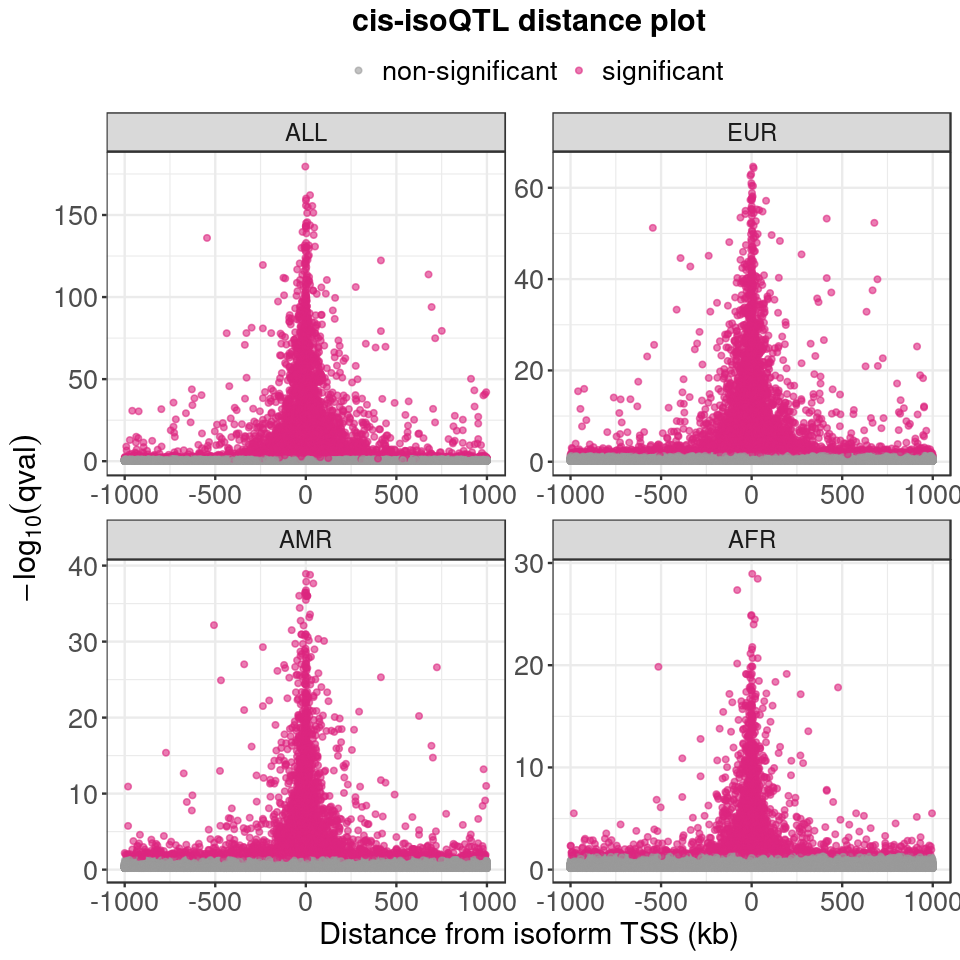

In [93]:
options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(df, aes(x = dist_kb)) +
    geom_point(aes(y = -log10(qval), color = sig), alpha = .6, size = 1.2) +
    facet_wrap (~Population, scales = "free") +
    labs(x = "Distance from isoform TSS (kb)",
         y = expression(-log[10](qval)),
         title = "cis-isoQTL distance plot",
         color = "") +
    theme_bw() +
    theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        legend.text = element_text(size = 16),
         legend.position = "top",
         strip.text.x = element_text(size = 14)) +
    scale_color_manual(values=c("#999999", "#DC267F")) 

In [95]:
ggsave("figures/dist.pdf", height = 8, width = 8)

### 7: Ancestry isoTx/isoGene UpsetR

In [96]:
mixed_tx <- unique(mixed_sig$pid)
eur_tx <- unique(eur_sig$pid)
amr_tx <- unique(amr_sig$pid)
afr_tx <- unique(afr_sig$pid)

tx <- list(ALL = mixed_tx,
            EUR = eur_tx,
            AMR = amr_tx,
            AFR = afr_tx)

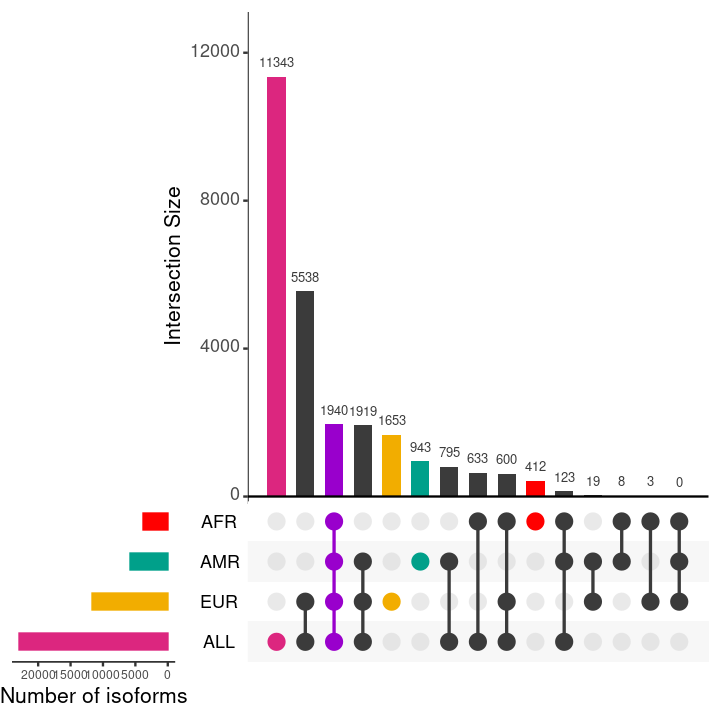

In [97]:
options(repr.plot.width = 6, repr.plot.height = 6)
upset(fromList(tx), order.by = "freq",
      sets.bar.color = c("#DC267F", "#F2AD00", "#00A08A", "#FF0000"),
      empty.intersections = "on",
      sets.x.label = "Number of isoforms",
      point.size = 4.5,
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","ALL"),
                          color = "#9900CC", active = T),
                     list(query = intersects, params = list("AFR"),
                          color = "#FF0000", active = T),
                     list(query = intersects, params = list("AMR"),
                          color = "#00A08A", active = T),
                     list(query = intersects, params = list("EUR"),
                          color = "#F2AD00", active = T),
                     list(query = intersects, params = list("ALL"),
                          color = "#DC267F", active = T)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))

In [98]:
pdf(file="figures/upsetr_isotx.pdf", onefile=F)
upset(fromList(tx), order.by = "freq",
      sets.bar.color = c("#DC267F", "#F2AD00", "#00A08A", "#FF0000"),
      empty.intersections = "on",
      sets.x.label = "Number of isoforms",
      point.size = 4.5,
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","ALL"),
                          color = "#9900CC", active = T),
                     list(query = intersects, params = list("AFR"),
                          color = "#FF0000", active = T),
                     list(query = intersects, params = list("AMR"),
                          color = "#00A08A", active = T),
                     list(query = intersects, params = list("EUR"),
                          color = "#F2AD00", active = T),
                     list(query = intersects, params = list("ALL"),
                          color = "#DC267F", active = T)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))
dev.off()

png 
  2

In [99]:
mixed_gene <- unique(mixed_sig$Gene)
eur_gene <- unique(eur_sig$Gene)
amr_gene <- unique(amr_sig$Gene)
afr_gene <- unique(afr_sig$Gene)

genes <- list(ALL = mixed_gene,
            EUR = eur_gene,
            AMR = amr_gene,
            AFR = afr_gene)

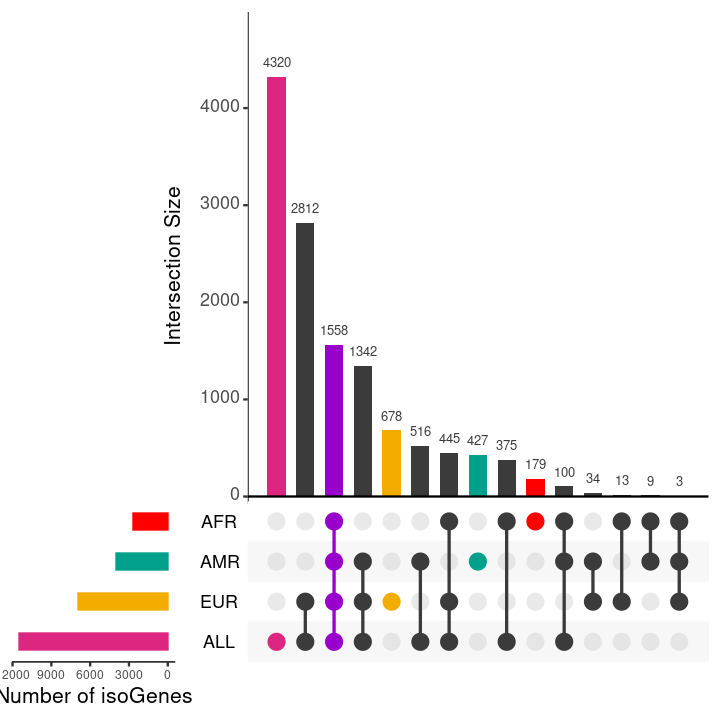

In [100]:
upset(fromList(genes), order.by = "freq",
      sets.bar.color = c("#DC267F", "#F2AD00", "#00A08A", "#FF0000"),
      empty.intersections = "on",
      sets.x.label = "Number of isoGenes",
      point.size = 4.5,
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","ALL"),
                          color = "#9900CC", active = T),
                     list(query = intersects, params = list("AFR"),
                          color = "#FF0000", active = T),
                     list(query = intersects, params = list("AMR"),
                          color = "#00A08A", active = T),
                     list(query = intersects, params = list("EUR"),
                          color = "#F2AD00", active = T),
                     list(query = intersects, params = list("ALL"),
                          color = "#DC267F", active = T)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))

In [101]:
pdf(file="figures/upsetr_isogene.pdf", onefile=F)
upset(fromList(genes), order.by = "freq",
      sets.bar.color = c("#DC267F", "#F2AD00", "#00A08A", "#FF0000"),
      empty.intersections = "on",
      sets.x.label = "Number of isoGenes",
      point.size = 4.5,
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","ALL"),
                          color = "#9900CC", active = T),
                     list(query = intersects, params = list("AFR"),
                          color = "#FF0000", active = T),
                     list(query = intersects, params = list("AMR"),
                          color = "#00A08A", active = T),
                     list(query = intersects, params = list("EUR"),
                          color = "#F2AD00", active = T),
                     list(query = intersects, params = list("ALL"),
                          color = "#DC267F", active = T)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))
dev.off()

png 
  2

### 8: (ABANDONED) Correlation of isoQTL effect sizes

In [35]:
mixed_nominal <- fread("results/mixed_nominal_70hcp/significant_assoc.txt", data.table = F)
eur_nominal <- fread("results/eur_nominal_60HCP/significant_assoc.txt", data.table = F)
amr_nominal <- fread("results/amr_nominal_15HCP/significant_assoc.txt", data.table = F)
afr_nominal <- fread("results/afr_nominal_20HCP/significant_assoc.txt", data.table = F)

In [36]:
# Note "gene" is actually isoform here, copied from eQTL
mixed_nominal <- mixed_nominal %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
eur_nominal <- eur_nominal %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
amr_nominal <- amr_nominal %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
afr_nominal <- afr_nominal %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)

In [37]:
# mixed, eur
mixed_eur <- mixed_nominal %>% inner_join(eur_nominal, by = "gene_snp")
mixed_eur_corr <- cor.test(x = abs(mixed_eur$slope.x), y = abs(mixed_eur$slope.y), method = 'spearman')
# mixed, amr
mixed_amr <- mixed_nominal %>% inner_join(amr_nominal, by = "gene_snp")
mixed_amr_corr <- cor.test(x = abs(mixed_amr$slope.x), y = abs(mixed_amr$slope.y), method = 'spearman')
# mixed, afr
mixed_afr <- mixed_nominal %>% inner_join(afr_nominal, by = "gene_snp")
mixed_afr_corr <- cor.test(x = abs(mixed_afr$slope.x), y = abs(mixed_afr$slope.y), method = 'spearman')
# eur, amr
eur_amr <- eur_nominal %>% inner_join(amr_nominal, by = "gene_snp")
eur_amr_corr <- cor.test(x = abs(eur_amr$slope.x), y = abs(eur_amr$slope.y), method = 'spearman')
# eur, afr
eur_afr <- eur_nominal %>% inner_join(afr_nominal, by = "gene_snp")
eur_afr_corr <- cor.test(x = abs(eur_afr$slope.x), y = abs(eur_afr$slope.y), method = 'spearman')
# amr, afr
amr_afr <- amr_nominal %>% inner_join(afr_nominal, by = "gene_snp")
amr_afr_corr <- cor.test(x = abs(amr_afr$slope.x), y = abs(amr_afr$slope.y), method = 'spearman')

Warning message in cor.test.default(x = abs(mixed_eur$slope.x), y = abs(mixed_eur$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(mixed_amr$slope.x), y = abs(mixed_amr$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(mixed_afr$slope.x), y = abs(mixed_afr$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(eur_amr$slope.x), y = abs(eur_amr$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(eur_afr$slope.x), y = abs(eur_afr$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(amr_afr$slope.x), y = abs(amr_afr$slope.y), :
“Cannot compute exact p-value with ties”


In [38]:
df <- data.frame("group1" = c(rep("ALL", 4), rep("EUR", 3), rep("AMR", 2), "AFR"),
                 "group2" = c("ALL", "EUR", "AMR", "AFR", "EUR", "AMR", "AFR", "AMR", "AFR", "AFR"),
                 "rho" = c(1, mixed_eur_corr$estimate, mixed_amr_corr$estimate, mixed_afr_corr$estimate, 
                           1, eur_amr_corr$estimate, eur_afr_corr$estimate, 
                           1, amr_afr_corr$estimate, 
                           1),
                 "shared" = c(nrow(mixed_nominal), nrow(mixed_eur), nrow(mixed_amr), nrow(mixed_afr),
                             nrow(eur_nominal), nrow(eur_amr), nrow(eur_afr),
                             nrow(amr_nominal), nrow(amr_afr),
                             nrow(afr_nominal)))
df <- df %>% mutate(display = paste0(signif(rho,4), "\n(", shared, ")"))
df

group1,group2,rho,shared,display
<chr>,<chr>,<dbl>,<int>,<chr>
ALL,ALL,1.0000000,3133855,1 (3133855)
ALL,EUR,0.8871040,1215166,0.8871 (1215166)
ALL,AMR,0.8442195,486280,0.8442 (486280)
ALL,AFR,0.8410881,182758,0.8411 (182758)
EUR,EUR,1.0000000,1512003,1 (1512003)
EUR,AMR,0.7840625,361381,0.7841 (361381)
EUR,AFR,0.7746984,120344,0.7747 (120344)
AMR,AMR,1.0000000,578845,1 (578845)
AMR,AFR,0.8074282,107379,0.8074 (107379)


In [39]:
df$group1 <- factor(df$group1, levels = c("ALL", "EUR", "AMR", "AFR"))
df$group2 <- factor(df$group2, levels = c("ALL", "EUR", "AMR", "AFR"))

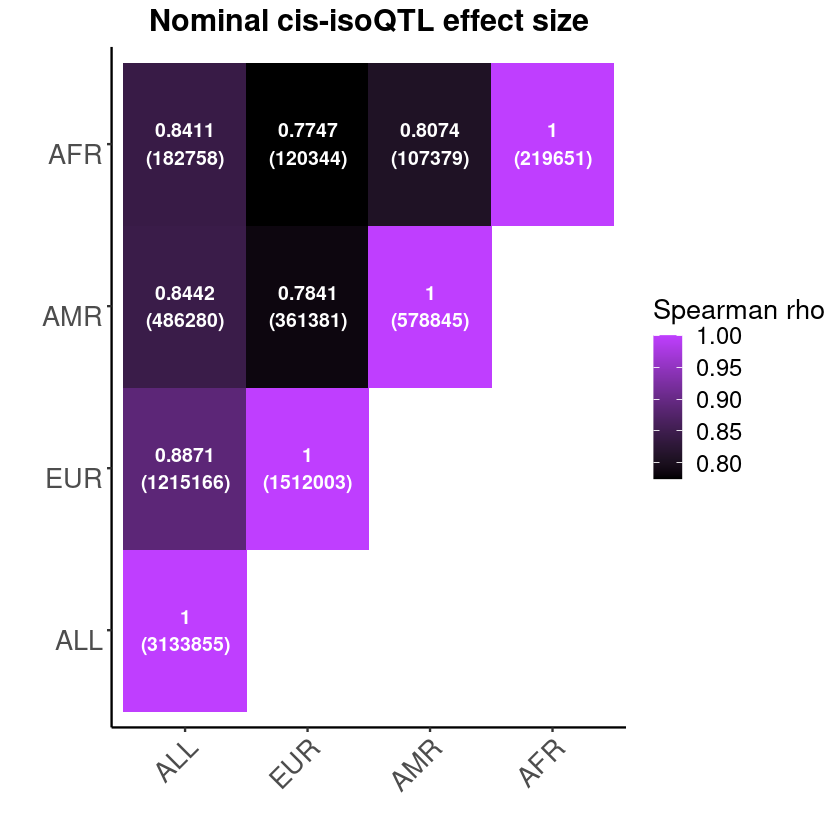

In [40]:
p <- ggplot(df, aes(x = group1, y = group2, fill = rho)) +
     geom_tile() +
     scale_fill_gradient( 
        name = "Spearman rho",
        low = "black", high = "darkorchid1") +
     theme_classic() + 
     labs(x = "", y = "", title = "Nominal cis-isoQTL effect size") +
     theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 16, hjust = 1),
           axis.text.y = element_text(vjust = 1, size = 16, hjust = 1),
           axis.title = element_text(size = 18),
           plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
           legend.title = element_text(size = 16),
           legend.text = element_text(size = 14),
           legend.position = "right") +
     geom_text(aes(label = display), color = "white", size = 4, fontface = "bold") 
p

In [41]:
ggsave("figures/corr_nominal.png", width = 6, height = 6)

In [42]:
mixed_sig <- mixed_sig %>% unite("gene_snp", pid, sid, sep = "-",remove = FALSE)
eur_sig <- eur_sig %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
amr_sig <- amr_sig %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
afr_sig <- afr_sig %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)

In [43]:
mixed_eur <- mixed_sig %>% inner_join(eur_sig, by = "gene_snp")
mixed_eur_corr <- cor.test(x = abs(mixed_eur$slope.x), y = abs(mixed_eur$slope.y), method = 'spearman')

mixed_amr <- mixed_sig %>% inner_join(amr_sig, by = "gene_snp")
mixed_amr_corr <- cor.test(x = abs(mixed_amr$slope.x), y = abs(mixed_amr$slope.y), method = 'spearman')

mixed_afr <- mixed_sig %>% inner_join(afr_sig, by = "gene_snp")
mixed_afr_corr <- cor.test(x = abs(mixed_afr$slope.x), y = abs(mixed_afr$slope.y), method = 'spearman')

eur_amr <- eur_sig %>% inner_join(amr_sig, by = "gene_snp")
eur_amr_corr <- cor.test(x = abs(eur_amr$slope.x), y = abs(eur_amr$slope.y), method = 'spearman')

eur_afr <- eur_sig %>% inner_join(afr_sig, by = "gene_snp")
eur_afr_corr <- cor.test(x = abs(eur_afr$slope.x), y = abs(eur_afr$slope.y), method = 'spearman')

amr_afr <- amr_sig %>% inner_join(afr_sig, by = "gene_snp")
amr_afr_corr <- cor.test(x = abs(amr_afr$slope.x), y = abs(amr_afr$slope.y), method = 'spearman')

Warning message in cor.test.default(x = abs(mixed_eur$slope.x), y = abs(mixed_eur$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(mixed_amr$slope.x), y = abs(mixed_amr$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(mixed_afr$slope.x), y = abs(mixed_afr$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(amr_afr$slope.x), y = abs(amr_afr$slope.y), :
“Cannot compute exact p-value with ties”


In [44]:
df <- data.frame("group1" = c(rep("ALL", 4), rep("EUR", 3), rep("AMR", 2), "AFR"),
                 "group2" = c("ALL", "EUR", "AMR", "AFR", "EUR", "AMR", "AFR", "AMR", "AFR", "AFR"),
                 "rho" = c(1, mixed_eur_corr$estimate, mixed_amr_corr$estimate, mixed_afr_corr$estimate, 
                           1, eur_amr_corr$estimate, eur_afr_corr$estimate, 
                           1, amr_afr_corr$estimate, 
                           1),
                 "shared" = c(nrow(mixed_sig), nrow(mixed_eur), nrow(mixed_amr), nrow(mixed_afr),
                             nrow(eur_sig), nrow(eur_amr), nrow(eur_afr),
                             nrow(amr_sig), nrow(amr_afr),
                             nrow(afr_sig)))

In [45]:
df <- df %>% mutate(display = paste0(signif(rho,4), "\n(", shared, ")"))
df$group1 <- factor(df$group1, levels = c("ALL", "EUR", "AMR", "AFR"))
df$group2 <- factor(df$group2, levels = c("ALL", "EUR", "AMR", "AFR"))

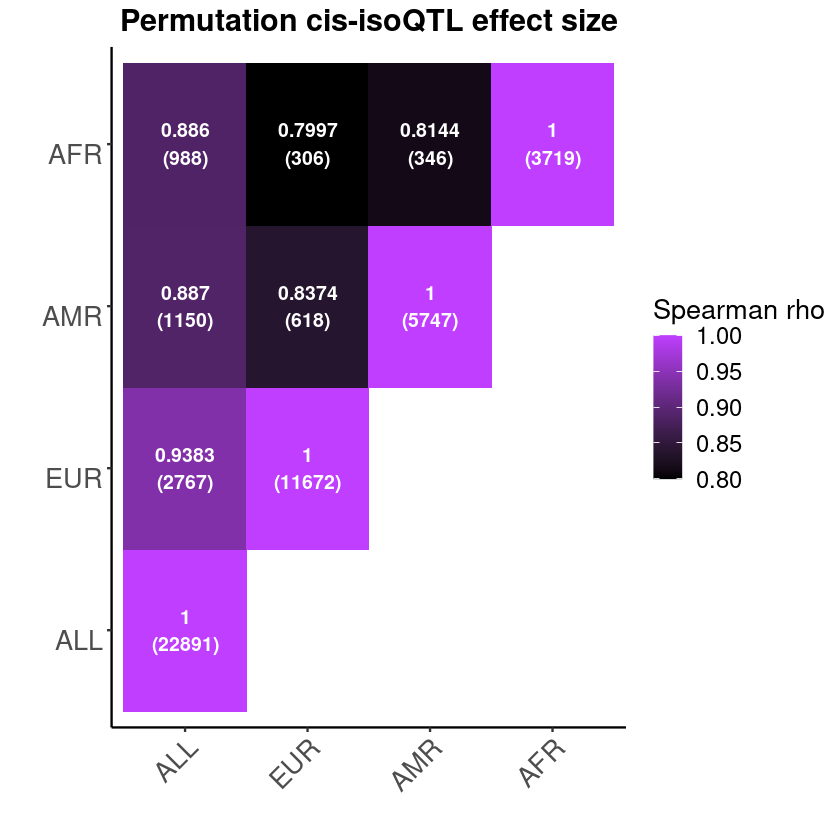

In [46]:
p <- ggplot(df, aes(x = group1, y = group2, fill = rho)) +
     geom_tile() +
     scale_fill_gradient( 
        name = "Spearman rho",
        low = "black", high = "darkorchid1") +
     theme_classic() + 
     labs(x = "", y = "", title = "Permutation cis-isoQTL effect size") +
     theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 16, hjust = 1),
           axis.text.y = element_text(vjust = 1, size = 16, hjust = 1),
           axis.title = element_text(size = 18),
           plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
           legend.title = element_text(size = 16),
           legend.text = element_text(size = 14),
           legend.position = "right") +
     geom_text(aes(label = display), color = "white", size = 4, fontface = "bold") 
p

In [47]:
ggsave("figures/corr_perm.png", width = 6, height = 6)

### 9: Compare with PEC

### 10: isoGene types

In [102]:
annot <- fread("~/project-gandalm/isoform_twas/salmon/gencode.v33lift37.annotation.gene.info.tsv", data.table=F)

In [46]:
mixed_sig <- mixed_sig %>% left_join(annot, by=c("Gene"="ensg"))

In [47]:
# no dist_kb column, ncol=26
dim(mixed_sig)

[1] 22891    27

In [14]:
mixed_sig <- mixed_sig[,c(1:14, 25, 26)]
colnames(mixed_sig)[15] <- "gene_type"
colnames(mixed_sig)[16] <- "gene_name"

In [20]:
write.table(mixed_sig, "results/mixed_perm_70hcp/sig_pheno_gene_info.txt", col.names=T, row.names=F, quote=F, sep="\t")

In [15]:
mixed_sig <- mixed_sig[!duplicated(mixed_sig$Gene),]

In [16]:
dim(mixed_sig)

[1] 11468    16

In [17]:
df <- as.data.frame(sort(table(mixed_sig$gene_type)))
df <- df[order(df$Freq, decreasing = TRUE),]
df <- df[c(1:4),]
df

,Var1,Freq
,<fct>,<int>
25,protein_coding,8074
24,lncRNA,2207
23,processed_pseudogene,323
22,transcribed_unprocessed_pseudogene,238


**Write output file with gene name and gene type for all permutation associations**

Note: w/o `dtss_kb` column

In [21]:
all_assoc <- all_assoc %>% left_join(annot, by=c("Gene"="ensg")) %>% select(c(1:14, 25, 26))
all_assoc_eur <- all_assoc_eur %>% left_join(annot, by=c("Gene"="ensg")) %>% select(c(1:14, 25, 26))
all_assoc_amr <- all_assoc_amr %>% left_join(annot, by=c("Gene"="ensg")) %>% select(c(1:14, 25, 26))
all_assoc_afr <- all_assoc_afr %>% left_join(annot, by=c("Gene"="ensg")) %>% select(c(1:14, 25, 26))

In [24]:
colnames(all_assoc)[15] <- "gene_type"
colnames(all_assoc)[16] <- "gene_name"
colnames(all_assoc_eur)[15] <- "gene_type"
colnames(all_assoc_eur)[16] <- "gene_name"
colnames(all_assoc_amr)[15] <- "gene_type"
colnames(all_assoc_amr)[16] <- "gene_name"
colnames(all_assoc_afr)[15] <- "gene_type"
colnames(all_assoc_afr)[16] <- "gene_name"

In [25]:
write.table(all_assoc, "results/mixed_perm_70hcp/all_assoc_perm_gene_info.txt", 
            col.names = T, row.names = F, quote = F, sep = "\t")
write.table(all_assoc_eur, "results/eur_perm_60HCP/all_assoc_perm_gene_info.txt", 
            col.names = T, row.names = F, quote = F, sep = "\t")
write.table(all_assoc_amr, "results/amr_perm_15HCP/all_assoc_perm_gene_info.txt", 
            col.names = T, row.names = F, quote = F, sep = "\t")
write.table(all_assoc_afr, "results/afr_perm_20HCP/all_assoc_perm_gene_info.txt", 
            col.names = T, row.names = F, quote = F, sep = "\t")

**Grouped permutation**

In [104]:
head(mixed_group_sig)

,gene_id,Tx,Gene,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,tss_distance,...,ref_factor,pval_nominal,slope,slope_se,pval_perm,pval_beta,group_id,group_size,qval,pval_nominal_threshold
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,...,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
1,ENST00000456328.2_1:ENSG00000223972,ENST00000456328.2_1,ENSG00000223972,846,1.03391,153.810,472.615,2.77306e-04,chr1:935662,859173,...,1,9.17017e-05,0.0480143,0.01218360,0.03329670,0.03696810,ENSG00000223972,1,0.03795780,0.000388848
2,ENST00000471248.1_4:ENSG00000238009,ENST00000471248.1_4,ENSG00000238009,1348,1.04404,773.424,485.930,2.47930e-05,rs1574243,707362,...,1,7.67478e-06,-0.0123557,0.00273514,0.01549850,0.01565090,ENSG00000238009,3,0.01813290,0.000079925
3,ENST00000416931.1_1:ENSG00000225972,ENST00000416931.1_1,ENSG00000225972,2853,1.05326,392.055,462.613,5.20347e-05,rs1153093,816172,...,1,1.08121e-05,-0.0455739,0.01026080,0.01399860,0.01603020,ENSG00000225972,1,0.01852530,0.000162356
4,ENST00000457540.1_1:ENSG00000225630,ENST00000457540.1_1,ENSG00000225630,2855,1.04353,424.609,471.427,1.42634e-04,rs112743287,623924,...,1,4.17822e-05,-0.0468198,0.01133390,0.04689530,0.05100720,ENSG00000225630,1,0.04930190,0.000145337
5,ENST00000414273.1_1:ENSG00000237973,ENST00000414273.1_1,ENSG00000237973,2859,1.03597,415.861,469.704,4.60535e-05,rs79432957,993139,...,1,1.09430e-05,-0.0508671,0.01145950,0.01479850,0.01619730,ENSG00000237973,1,0.01870520,0.000144815
6,ENST00000514057.1_1:ENSG00000248527,ENST00000514057.1_1,ENSG00000248527,2862,1.03648,438.862,475.607,1.38399e-05,rs145904956,804491,...,1,3.13883e-06,-0.0434631,0.00922708,0.00439956,0.00494756,ENSG00000248527,1,0.00644575,0.000137453


In [106]:
mixed_group_sig <- mixed_group_sig %>% left_join(annot, by = c("Gene" = "ensg"))

In [107]:
colnames(mixed_group_sig)

[1] "gene_id"                "Tx"                     "Gene"                  
 [4] "num_var"                "beta_shape1"            "beta_shape2"           
 [7] "true_df"                "pval_true_df"           "variant_id"            
[10] "tss_distance"           "ma_samples"             "ma_count"              
[13] "maf"                    "ref_factor"             "pval_nominal"          
[16] "slope"                  "slope_se"               "pval_perm"             
[19] "pval_beta"              "group_id"               "group_size"            
[22] "qval"                   "pval_nominal_threshold" "V1"                    
[25] "V2"                     "V3"                     "V4"                    
[28] "V5"                     "V6"                     "V7"                    
[31] "V8"                     "V9"                     "version"               
[34] "V11"                    "V12"

In [108]:
length(unique(mixed_group_sig$Gene))
dim(mixed_group_sig)

[1] 11845

[1] 11861    35

In [109]:
mixed_group_sig <- mixed_group_sig[!duplicated(mixed_group_sig$Gene),]

In [110]:
dim(mixed_group_sig)

[1] 11845    35

In [112]:
df <- as.data.frame(sort(table(mixed_group_sig$V11)))
df <- df[order(df$Freq, decreasing = TRUE),]
df <- df[c(1:4),]
df$Var1 <- as.character(df$Var1)
df

,Var1,Freq
,<chr>,<int>
26,protein_coding,7701
25,lncRNA,2607
24,processed_pseudogene,435
23,transcribed_unprocessed_pseudogene,253


In [113]:
df[5,] <- c("Other", (11845-7701-2607-435-253))
df <- df %>% mutate(prop = as.numeric(Freq)/11845)
df

,Var1,Freq,prop
,<chr>,<chr>,<dbl>
26,protein_coding,7701,0.65014774
25,lncRNA,2607,0.22009287
24,processed_pseudogene,435,0.03672436
23,transcribed_unprocessed_pseudogene,253,0.02135922
5,Other,849,0.07167581


In [114]:
df$Var1 <- factor(df$Var1, levels = c("protein_coding", "lncRNA", "processed_pseudogene", "transcribed_unprocessed_pseudogene", "Other"))

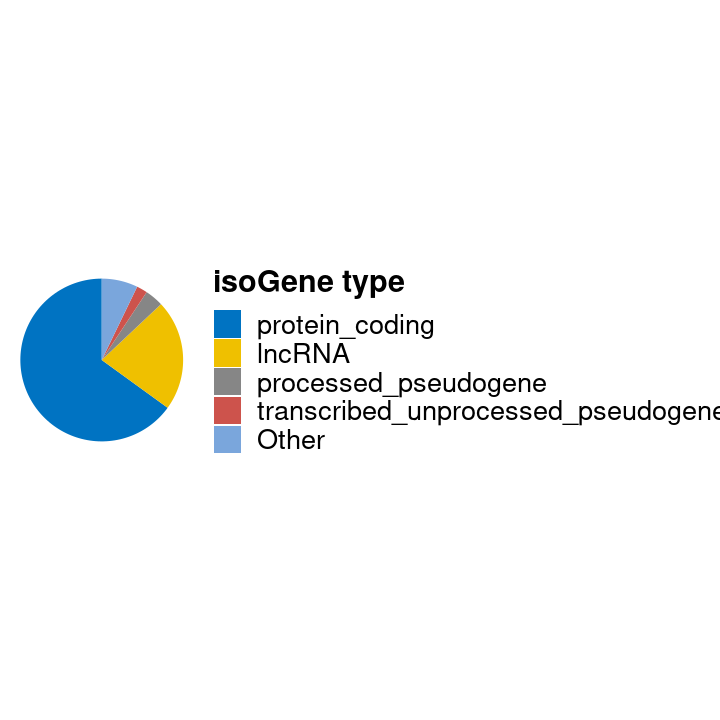

In [116]:
ggplot(df, aes(x = "", y = prop, fill = Var1)) +
  geom_bar(width = 1, stat = "identity") +
  coord_polar("y", start = 0) +
  theme_void() +
  theme(legend.text = element_text(size = 16),
        legend.title = element_text(size = 18, face = "bold")) +
  scale_fill_jco() +
  labs(fill = "isoGene type") 

In [117]:
ggsave("figures/isogene_type.pdf", height = 6, width = 8.5)

### 11: Conditional isoQTL

**Top variants per rank of all expressed isoforms**

In [11]:
dat <- fread("results/mixed_conditional_70hcp/conditional_top_variants.txt", data.table = F)

**Check TSS**

In [4]:
dim(dat)
sum(dat$V3+dat$V7==dat$V10)
sum(dat$V3+dat$V7==dat$V11)
sum(!(dat$V3+dat$V7) %in% c(dat$V10, dat$V11))

[1] 32062    20

[1] 30939

[1] 30967

[1] 0

In [5]:
dat %>% filter(V7 == 0)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
ENST00000586591.1_1,18,12438889,12438889,+,7025,0,rs12964631,18,12438889,12438889,1,1.30434e-12,-0.399292,1,1,1.59533e-14,-0.430788,1,1
ENST00000463848.1_1,7,891187,891187,+,7647,0,chr7:851547,7,891184,891187,0,2.80785e-18,-0.556015,1,1,2.80785e-18,-0.556015,1,1
ENST00000527128.5_1,9,100000731,100000731,+,5358,0,rs7856254,9,100000731,100000731,0,2.32361e-14,1.277140,1,1,2.32361e-14,1.277140,1,1


In [6]:
table(dat$V19)
table(dat$V20)


    1 
32062 


    0     1 
   16 32046 

**Remove variants with backward P-value that is not below the threshold of this feature**

In [12]:
dat <- dat %>% filter(V20 == 1)

**Check features with significant conditional QTL are mostly isoforms with permutation isoQTL**

In [50]:
length(unique(mixed_sig$pid))
length(unique(dat$V1))
sum(unique(mixed_sig$pid) %in% unique(dat$V1))

[1] 22891

[1] 24122

[1] 20246

**How many ranks/independent QTL each feature has? (+1 because primary QTL is rank 0)**

In [120]:
table(dat$V12)


    0     1     2     3     4     5     6     7 
24108  5611  1577   527   157    47    16     3 


    1     2     3     4     5     6     7     8 
18506  4033  1054   371   111    31    13     3 

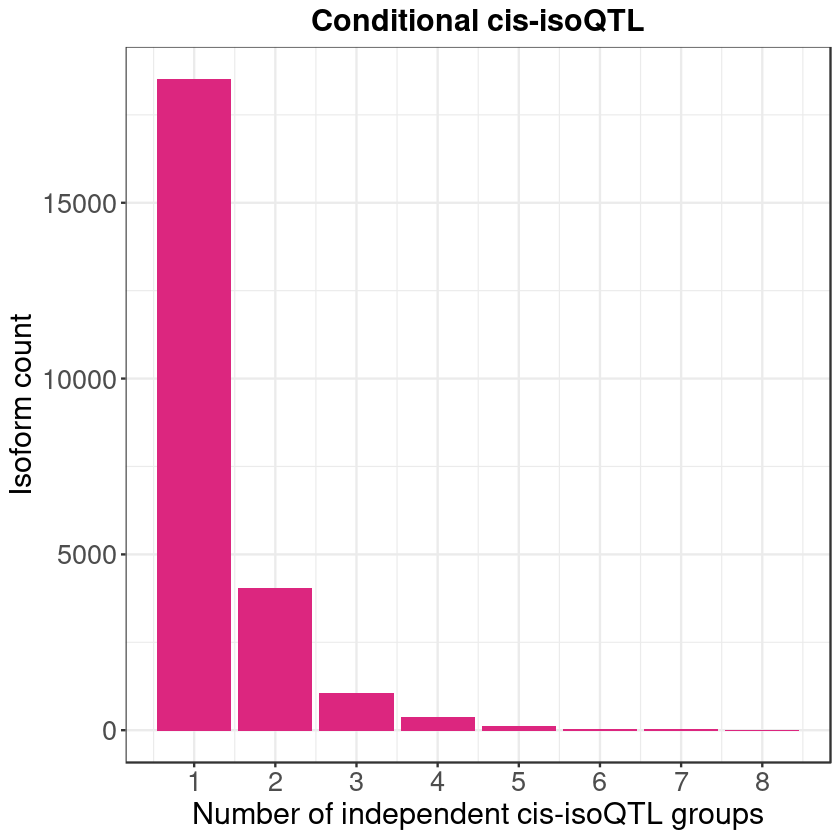

In [13]:
df_cond <- data.frame("isoform" <- unique(dat$V1),
                      "num_rank" <- NA)
for (i in 1:nrow(df_cond)) {
  isoform <- df_cond[i,1]
  df_cond[i,2] <- max(dat[dat$V1==isoform,12]) + 1
}
names(df_cond) <-c("isoform","num_rank")
table(df_cond$num_rank)

ggplot(df_cond, aes(x = num_rank)) +
  geom_bar(fill = "#DC267F") +
  scale_x_continuous(breaks = seq(1,8,by = 1)) +
  labs(x = "Number of independent cis-isoQTL groups", y = "Isoform count") +
  ggtitle("Conditional cis-isoQTL") +
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust=0.5))

In [122]:
ggsave("figures/condition_rank.pdf", height = 6, width = 6)

**Primary and seconday distance to TSS**

In [123]:
dat2 <- filter(dat, V12 <= 1)
dat2$tss_kb <- dat2$V7/1000

dat2$Rank <- ifelse(dat2$V12==0, "1st", "2nd")

# p2 <- ggplot(dat2, aes(x=tss_kb, color=Rank)) +
#   geom_density(size=.8) +
#   labs(x="Distance from TSS (kb)") +
#   ggtitle("Conditional cis-isoQTL analysis", subtitle = "Combined ancestry, 70HCP") +
#   theme_classic() +
#   theme(axis.text = element_text(size=10),
#         axis.title = element_text(size=12),
#         plot.title = element_text(size=16, face="bold", hjust=0.5),
#         plot.subtitle = element_text(size=14, hjust=0.5))
# p2

In [55]:
# ggsave("figures/condition_dtss.png", p2, height=6, width=6)

In [124]:
table(dat2$Rank)


  1st   2nd 
24108  5611 

In [125]:
primary <- dat2 %>% filter(Rank == "1st")
secondary <- dat2 %>% filter(Rank == "2nd")
median(primary$tss_kb)
median(secondary$tss_kb)

[1] -0.045

[1] 0.044

In [126]:
wilcox.test(abs(primary$tss_kb), abs(secondary$tss_kb), alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  abs(primary$tss_kb) and abs(secondary$tss_kb)
W = 53391678, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


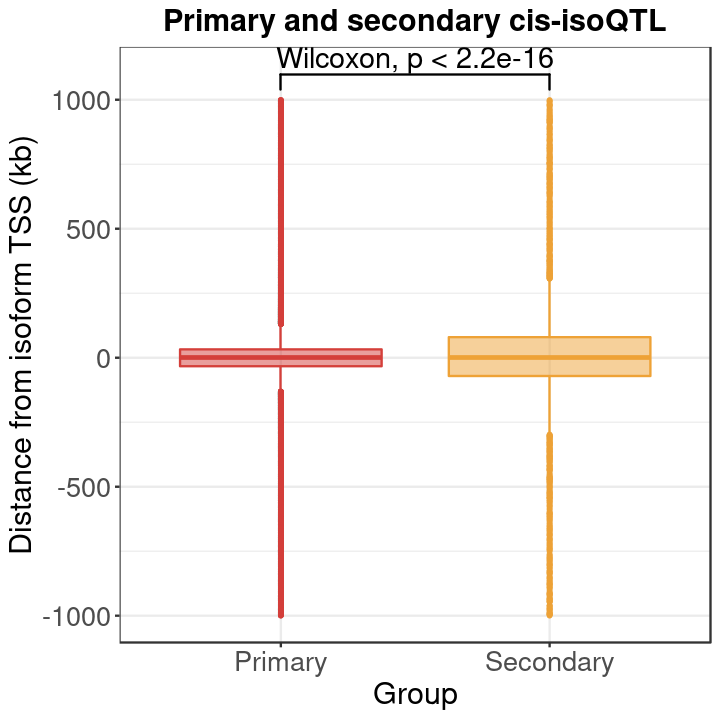

In [127]:
df <- data.frame("Group"=c(rep("Primary", 24108), rep("Secondary", 5611)),
                "TSS_kb"=c(primary$tss_kb, secondary$tss_kb))

ggplot(df, aes(x = Group, y = TSS_kb, color = Group, fill = Group)) +
    geom_boxplot(outlier.shape = 16, outlier.size = 1, alpha = 0.5) +
#     geom_violin(alpha = 0.3, trim = TRUE) +
    theme_bw() +
    labs(x = "Group", y = "Distance from isoform TSS (kb)", title = "Primary and secondary cis-isoQTL") +
    theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
         legend.position = "none") +
geom_signif(
        comparisons = list(c("Primary", "Secondary")),
        annotation = "Wilcoxon, p < 2.2e-16",
        textsize = 6,
        color = "black"
  ) +
scale_color_locuszoom() +
scale_fill_locuszoom()

In [128]:
ggsave("figures/conditional_dtss_2.pdf", height = 6, width = 6)

**1st-4th**

In [129]:
dat3 <- filter(dat, V12 <= 3)
dat3$tss_kb <- dat3$V7/1000
dat3 %>% group_by(V12) %>% summarise(median(tss_kb), mean(tss_kb))

V12,median(tss_kb),mean(tss_kb)
<int>,<dbl>,<dbl>
0,-0.045,-0.9788922
1,0.044,3.8704773
2,3.841,3.6104451
3,-7.573,-6.3737078


In [130]:
dat3 <- dat3 %>% mutate(Rank = case_when(V12 == 0 ~ "1st, median=-0.045, mean=-0.979",
                                 V12 == 1 ~ "2nd, median=0.044, mean=3.870",
                                 V12 == 2 ~ "3rd, median=3.841, mean=3.610",
                                 V12 == 3 ~ "4th, median=-7.573, mean=-6.373"))
table(dat3$Rank)
dat3$Rank <- factor(dat3$Rank, levels = c("1st, median=-0.045, mean=-0.979", 
                                          "2nd, median=0.044, mean=3.870", 
                                          "3rd, median=3.841, mean=3.610", 
                                          "4th, median=-7.573, mean=-6.373"))


1st, median=-0.045, mean=-0.979   2nd, median=0.044, mean=3.870 
                          24108                            5611 
  3rd, median=3.841, mean=3.610 4th, median=-7.573, mean=-6.373 
                           1577                             527 

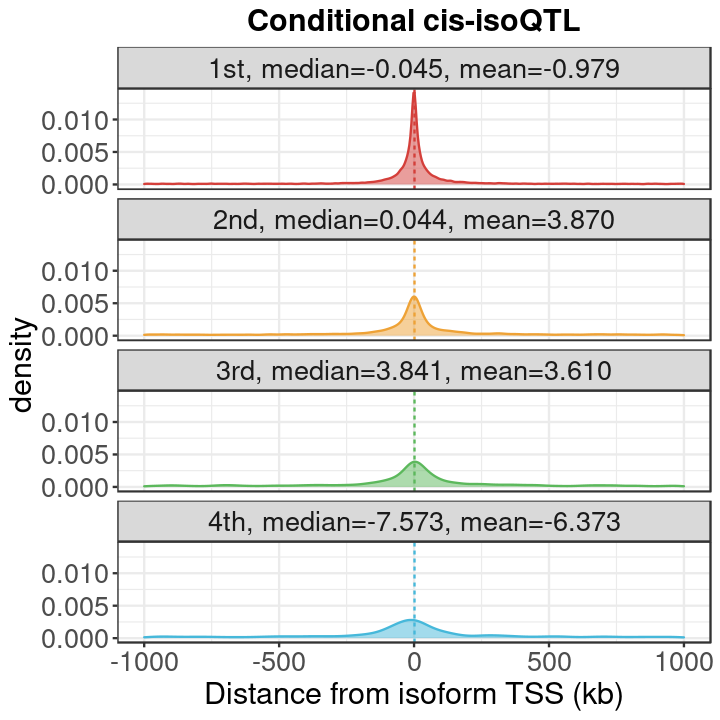

In [131]:
ggplot(dat3, aes(x = tss_kb, fill = Rank, color = Rank)) +
  geom_density(alpha = .5) +
  geom_vline(aes(xintercept = median(tss_kb), color = Rank), linetype = 2, size = .5) +
  facet_wrap(~Rank, nrow = 4) +
  labs(x = "Distance from isoform TSS (kb)") +
  ggtitle("Conditional cis-isoQTL") +
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        legend.position = "none",
        strip.text.x = element_text(size = 16)) +
scale_color_locuszoom() +
scale_fill_locuszoom()

In [132]:
ggsave("figures/condition_dtss_4.pdf", width = 6, height = 6)

In [64]:
# p2 <- ggplot(dat3, aes(x = tss_kb, fill = Rank, color = Rank)) +
#   geom_density(alpha = .4) +
#   labs(x="Distance from TSS (kb)") +
#   ggtitle("Conditional cis-isoQTL analysis", subtitle = "Combined ancestry, 70HCP") +
#   theme_classic() +
#   theme(axis.text = element_text(size=10),
#         axis.title = element_text(size=12),
#         plot.title = element_text(size=16, face="bold", hjust=0.5),
#         plot.subtitle = element_text(size=14, hjust=0.5))
# p2

### 12: SuSiE results

- We started with 22891 isoTx identified by FastQTL permutation pass for mixed ancestries with 70 HCP in covariates
- After filtering for CS purity: 
    - 18111 isoforms have non-low purity CS
    - 23211 unique CS
    - 225,218 unique variants in CS    
- Of the 23211 CS:
    - 4702 contain exactly one SNP (strong candidates for causal variants)
    - 2614 contain exactly two SNPs
    - median size 5
- Of the 18111 isoforms:
    - 14380 have exactly one CS
    - up to 7

**File: all variants that belong to a non-low purity credible set**

Other files: 
- all credible sets (not filtered for purity)
- all tested variants

In [3]:
var_in_cs <- fread("results/susie_finemap/mixed_cisisoqtl_70hcp_perm.txt.gz", data.table = F)
dim(var_in_cs)

[1] 423607     17

**How many isoforms got finemapped non-low purity credible sets?**

In [4]:
length(unique(var_in_cs$phenotype_id))

[1] 18111

**How many unique variants in all CS?**

In [5]:
length(unique(var_in_cs$variant_id))

[1] 225218

**How many unique non-low purity CS?**

In [6]:
length(unique(var_in_cs$cs_id))

[1] 23211

**Sorted by chr and pos of isoforms**

In [6]:
sorted_df <- fread("results/susie_finemap/mixed_cisisoqtl_70hcp_perm_purity_filtered.txt.gz", data.table = F)

**How many CS contain exactly one SNP?**

In [57]:
cs_id_size <- sorted_df[!duplicated(sorted_df$cs_id),] %>% select(cs_id, cs_size, finemapped_region)

In [68]:
sum(cs_id_size$cs_size==1)
sum(cs_id_size$cs_size==2)

[1] 4702

[1] 2614

In [69]:
summary(cs_id_size$cs_size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    5.00   18.25   15.00 2164.00 

**Note chr 17 region has large CS**

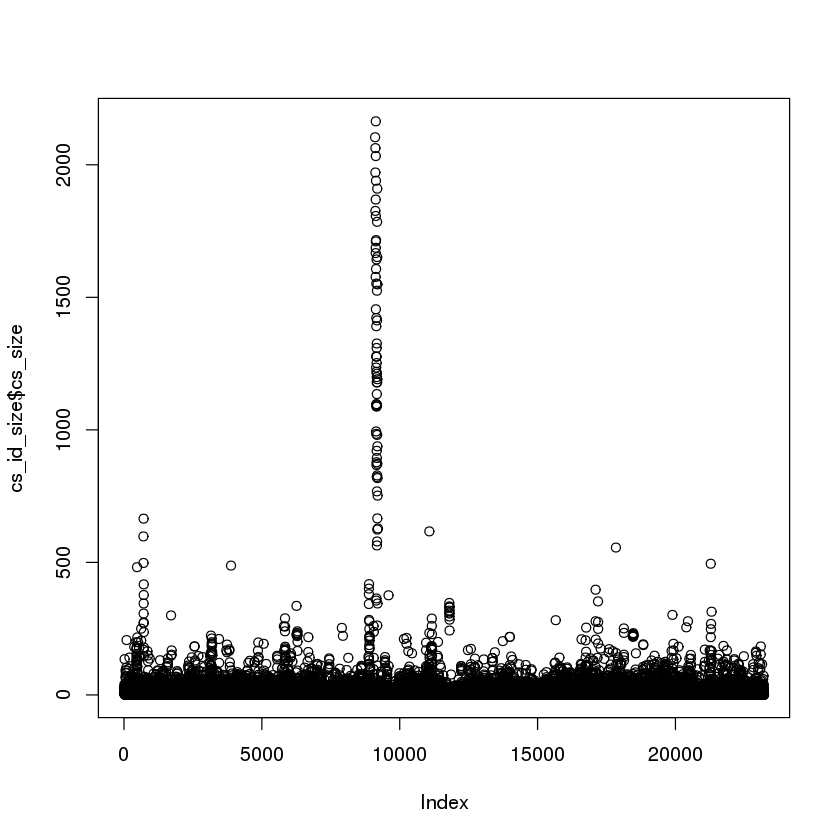

In [12]:
plot(cs_id_size$cs_size)

In [58]:
cs_id_size %>% filter(cs_size > 500) %>% head()

,cs_id,cs_size,finemapped_region
,<chr>,<int>,<chr>
1,ENST00000621900.1_1_L1,598,chr10:73885289-75885289
2,ENST00000488223.5_1_L1,665,chr10:73870216-75870216
3,ENST00000587960.1_1_L3,2104,chr17:42608942-44608942
4,ENST00000329196.7_2_L1,1826,chr17:42922246-44922246
5,ENST00000585677.1_1_L1,1971,chr17:42716340-44716340
6,ENST00000570299.5_1_L1,2063,chr17:42971941-44971941


**How many isoforms have exactly one CS?**

In [7]:
iso_with_cs <- unique(sorted_df$phenotype_id)
df <- data.frame("isoform" = iso_with_cs,
                 "cs_count" = NA)
for(i in 1:nrow(df)) {
    df[i,2] <- length(unique(sorted_df[sorted_df$phenotype_id == df[i,1],]$cs_id))
}

In [8]:
summary(df$cs_count)
sum(df$cs_count == 1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.282   1.000   7.000 

[1] 14380

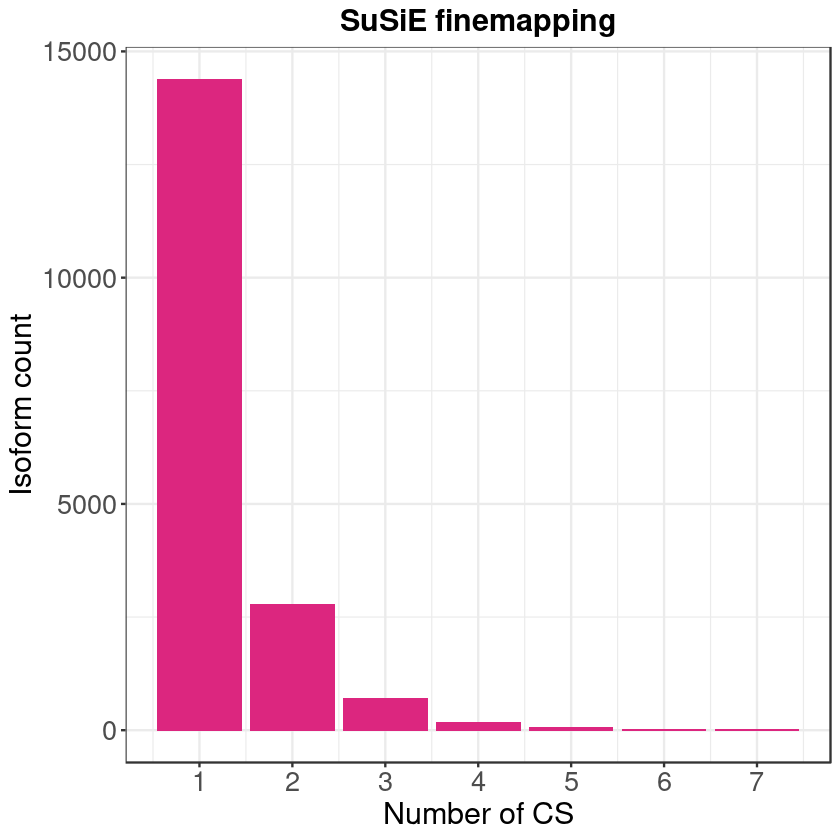

In [9]:
ggplot(df, aes(x = cs_count)) +
  geom_bar(fill = "#DC267F") +
  scale_x_continuous(breaks = seq(1,7,by=1)) +
  labs(x = "Number of CS", y = "Isoform count") +
  ggtitle("SuSiE finemapping") +
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5))

In [10]:
ggsave("figures/susie_num_cs.pdf", width = 6, height = 6)

**Number of independent signals compared to conditional QTL mapping**

In [14]:
sum(df$isoform %in% df_cond$isoform)

[1] 17027

In [15]:
df2 <- df %>% inner_join(df_cond)
sum(complete.cases(df2))
dim(df2)

Joining, by = "isoform"



[1] 17027

[1] 17027     3


Attaching package: ‘ggpubr’


The following object is masked from ‘package:VennDiagram’:

    rotate


`geom_smooth()` using formula 'y ~ x'



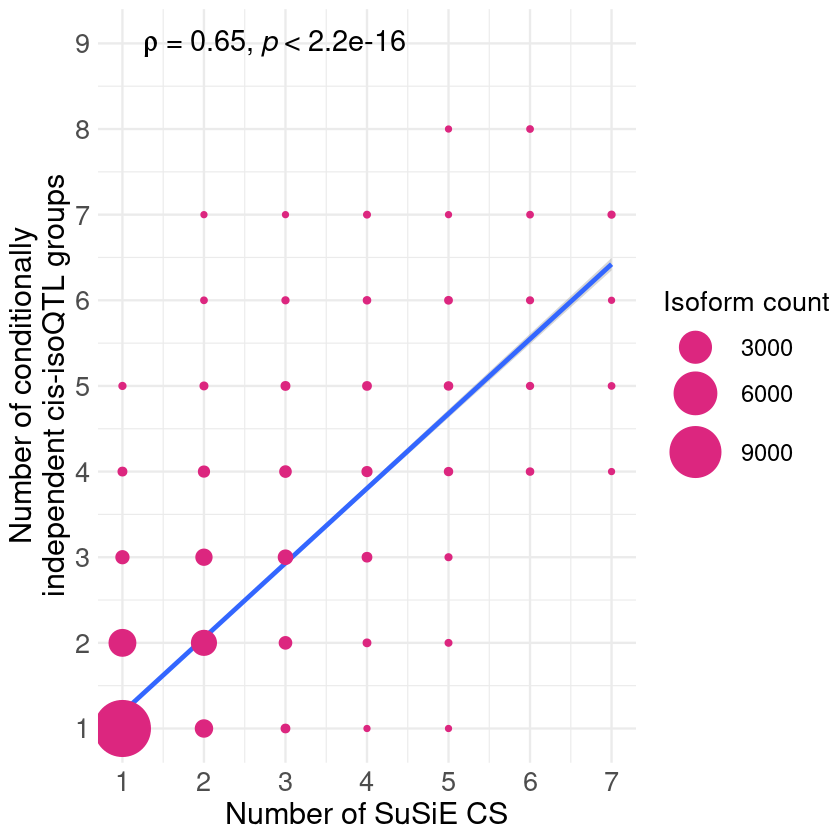

In [17]:
library(ggpubr)

ggplot(df2, aes(x = cs_count, y = num_rank)) +
      geom_smooth(method = "lm", fullrange = TRUE) +
     geom_count(color = "#DC267F") +
#   geom_count(aes(color = ..n..), size=5) +
     scale_size(range = c(1, 15), "Isoform count") + 
#   geom_hex() +
  labs(x = "Number of SuSiE CS", y = "Number of conditionally\nindependent cis-isoQTL groups") +
#   ggtitle("17027 isoforms in common") +
  theme_minimal() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14)) +
  scale_x_continuous(breaks = seq(1,8,by=1)) +
  scale_y_continuous(breaks = seq(1,10,by=1)) +
    stat_cor(method = "spearman", label.x = 1.25, label.y = 9, cor.coef.name = "rho", size = 6)

In [18]:
ggsave("figures/susie_conditional.pdf", width = 8, height = 6)

`geom_smooth()` using formula 'y ~ x'



In [20]:
cor(df2$cs_count, df2$num_rank, method = 'spearman')
cor(df2$cs_count, df2$num_rank, method = 'pearson')

0.6459626


0.7201606


**sum of PIP in CS**

In [33]:
cs_sum_pip <- sorted_df %>% group_by(cs_id) %>% summarise(sum_pip = sum(pip))
summary(cs_sum_pip)

`summarise()` ungrouping output (override with `.groups` argument)



    cs_id              sum_pip      
 Length:23211       Min.   :0.9500  
 Class :character   1st Qu.:0.9639  
 Mode  :character   Median :0.9777  
                    Mean   :0.9815  
                    3rd Qu.:0.9978  
                    Max.   :1.8221  